This notebook is for training the network for MNIST dataset.

In [1]:
import numpy as np
import theano
import theano.tensor as T 
import lasagne
from __future__ import print_function

import BC_layers
import BC_utils
from pylearn2.datasets.mnist import MNIST
from pylearn2.utils import serial
import timeit
import inspect
import time
import logging
import scipy.io
from lasagne.layers import batch_norm

__docformat__ = 'restructedtext en'
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 3007.)


The original implementation use a script for pre-processing. I also found preprocessing script [here](https://github.com/lisa-lab/pylearn2/blob/master/pylearn2/scripts/papers/maxout/svhn_preprocessing.py), and it seems that it is from the codes for Maxout Network. So here in order to make sure I have the same preprocessing result, I use the same code in the link.

Moreover, the code for downloading and splitting the data is from [here](https://raw.githubusercontent.com/lisa-lab/pylearn2/master/pylearn2/scripts/datasets/download_svhn.sh), also in the pylearn2 library. Although we can also use the code in the previous homeworks, here I use that code for consistency of the overall training.

In [2]:
# make logging functions

logger = logging.getLogger('')
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler('experiment.log')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(message)s')
ch.setFormatter(formatter)
fh.setFormatter(formatter)
logger.addHandler(ch)
logger.addHandler(fh)

Again, here I use the same code to load the data.

In [3]:
train_set = MNIST(which_set= 'train', start=0, stop = 50000, center = True)
valid_set = MNIST(which_set= 'train', start=50000, stop = 60000, center = True)
test_set = MNIST(which_set= 'test', center = True)
    
# bc01 format
# print train_set.X.shape
train_set.X = train_set.X.reshape(-1, 1, 28, 28)
valid_set.X = valid_set.X.reshape(-1, 1, 28, 28)
test_set.X = test_set.X.reshape(-1, 1, 28, 28)
    
# flatten targets
train_set.y = np.hstack(train_set.y)
valid_set.y = np.hstack(valid_set.y)
test_set.y = np.hstack(test_set.y)

# for hinge loss 
# make targets onehot
def make_onehot(dataset, category=10):
    n_dataset = np.zeros((dataset.shape[0], category), dtype=np.int32)
    n_dataset[np.arange(n_dataset.shape[0]), dataset] = 1
    return n_dataset

train_set.y = np.subtract(np.multiply(2,make_onehot(train_set.y)),1.).astype('int32')
valid_set.y = np.subtract(np.multiply(2,make_onehot(valid_set.y)),1.).astype('int32')
test_set.y = np.subtract(np.multiply(2,make_onehot(test_set.y)),1.).astype('int32')

In [4]:
# make dataset shared variables
from theano import shared
train_set_x = shared(train_set.X, borrow=True)
train_set_y = shared(train_set.y, borrow=True)
valid_set_x = shared(valid_set.X, borrow=True)
valid_set_y = shared(valid_set.y, borrow=True)
test_set_x = shared(test_set.X, borrow=True)
test_set_y = shared(test_set.y, borrow=True)

In [5]:
def make_network(input_shape, net_arch, net_spec):
    assert len(net_arch) == len(net_spec)
    
    layer = lasagne.layers.InputLayer(shape=input_shape)
    
    layers = {'in': layer}

    for i in range(len(net_arch)):
        if net_arch[i]=='noise':
            lasagne.layers.GaussianNoiseLayer(layer,**net_spec[i])
        
        elif net_arch[i]=='dropout':
            layer = lasagne.layers.DropoutLayer(layer,**net_spec[i])
        
        elif net_arch[i]=='reshape':
            layer = lasagne.layers.ReshapeLayer(layer,**net_spec[i])
        
        elif net_arch[i]=='cnn':
            layer = BC_layers.Conv2DLayer(layer, **net_spec[i])
        
        elif net_arch[i]=='bn':
            layer = batch_norm(layer, **net_spec[i])
            
        elif net_arch[i]=='maxpool':
            layer = lasagne.layers.MaxPool2DLayer(layer, **net_spec[i])
            
        elif net_arch[i][:11]=='feedforward':
            if net_arch[i]=='feedforward_tanh':
                nonlinearity = lasagne.nonlinearities.tanh
            elif net_arch[i]=='feedforward_sigmoid':
                nonlinearity = lasagne.nonlinearities.sigmoid
            elif net_arch[i]=='feedforward_softmax':
                nonlinearity = lasagne.nonlinearities.softmax
            elif net_arch[i]=='feedforward_linear':
                nonlinearity = lasagne.nonlinearities.linear
            elif net_arch[i]=='feedforward_rectify':
                nonlinearity = lasagne.nonlinearities.rectify
            elif net_arch[i]=='feedforward_leaky':
                nonlinearity = lasagne.nonlinearities.leaky_rectify
            elif net_arch[i]=='feedforward_identity':
                nonlinearity = lasagne.nonlinearities.identity
                
            layer = BC_layers.DenseLayer(layer,nonlinearity=nonlinearity,**net_spec[i])
                
                
    layers['out'] = layer
    return layers

In [6]:
def exp_setting(binary, stochastic, dropout, batch_size=200, learning_rate=3e-4, n_epoch=1000):
    if not dropout:
        net_arch=['feedforward_rectify', 'bn', 'feedforward_rectify', 'bn', 'feedforward_rectify', 'bn', 
                  'feedforward_identity', 'bn']

        net_spec=[{'binary':binary,'stochastic':stochastic,'num_units':1024}, 
                  {'name': 'batch norm 1'}, 
                  {'binary':binary,'stochastic':stochastic,'num_units':1024}, 
                  {'name': 'batch norm 2'}, 
                  {'binary':binary,'stochastic':stochastic,'num_units':1024}, 
                  {'name': 'batch norm 3'}, 
                  {'binary':binary,'stochastic':stochastic,'num_units':10}, 
                  {'name': 'batch norm 4'}]
    else:
        # with dropout probability 0.5
        net_arch=['feedforward_rectify', 'bn', 'dropout', 'feedforward_rectify', 'bn', 'dropout', 
                  'feedforward_rectify', 'bn', 'dropout', 
                  'feedforward_identity', 'bn']

        net_spec=[{'binary':binary,'stochastic':stochastic,'num_units':1024}, 
                  {'name': 'batch norm 1'}, {'p': 0.5}, 
                  {'binary':binary,'stochastic':stochastic,'num_units':1024}, 
                  {'name': 'batch norm 2'}, {'p': 0.5}, 
                  {'binary':binary,'stochastic':stochastic,'num_units':1024}, 
                  {'name': 'batch norm 3'}, {'p': 0.5}, 
                  {'binary':binary,'stochastic':stochastic,'num_units':10}, 
                  {'name': 'batch norm 4'}]
        
    input_shape=(None, 1, 28, 28)
    Layer = make_network(input_shape,net_arch,net_spec)

    input = T.ftensor4('input')
    Y = T.imatrix('Y')
    LR = T.fscalar('learning_rate')
    
    # cost function
    # hinge loss
    cost_tr = T.mean(T.sqr(T.maximum(0.,1. - Y * lasagne.layers.get_output(Layer['out'], 
                                                                         {Layer['in']: input}, deterministic=False))))
    # compute update
    # It is said in the paper that they use sgd without momentum. However, sgd does not work!
    # Moreover, in their implementation, they also use adam.
    update = BC_utils.calculate_update(Layer, cost_tr, LR, method='adam', binary=binary)
    
    # other functions
    cost_cv = T.mean(T.sqr(T.maximum(0.,1. - Y * lasagne.layers.get_output(Layer['out'], 
                                                                         {Layer['in']: input}, deterministic=True))))
    error_model = T.mean(T.neq(T.argmax(lasagne.layers.get_output(Layer['out'], \
                                                               {Layer['in']: input}, deterministic=True), axis=1), 
                            T.argmax(Y, axis=1)), dtype='float32')
    
    n_train_batches = train_set_x.get_value(borrow=True).shape[0]
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
    n_test_batches = test_set_x.get_value(borrow=True).shape[0]
    n_train_batches //= batch_size
    n_valid_batches //= batch_size
    n_test_batches //= batch_size


    index = T.lscalar()

    import time
    start_time = time.time()

    logger.info('Computing function for training...')
    train_model = theano.function(
            inputs=[index, LR],
            outputs=cost_tr,
            updates=update,
            givens={
                input: train_set_x[index * batch_size: (index + 1) * batch_size],
                Y: train_set_y[index * batch_size: (index + 1) * batch_size]
            }
        )

    print('Time spent: ', time.time() - start_time)

    logger.info('Compiling cost function for testing...')
    test_model = theano.function(
            inputs=[index],
            outputs=error_model,
            givens={
                input: test_set_x[index * batch_size:(index + 1) * batch_size],
                Y: test_set_y[index * batch_size:(index + 1) * batch_size]
            }
        )
    print('Time spent: ', time.time() - start_time)

    logger.info('Compiling cost function for validation...')
    validate_model = theano.function(
            inputs=[index],
            outputs=error_model,
            givens={
                input: valid_set_x[index * batch_size:(index + 1) * batch_size],
                Y: valid_set_y[index * batch_size:(index + 1) * batch_size]
            }
        )
    print('Time spent: ', time.time() - start_time)
    
    
    # training function
    def train_nn(train_model, validate_model, test_model, LR, 
                n_train_batches, n_valid_batches, n_test_batches, n_epochs,
                verbose = True):
        """
        Function from HW3

        """

        # early-stopping parameters
        patience = 1e9  # look as this many examples regardless
        patience_increase = 15  # wait this much longer when a new best is
                               # found
        improvement_threshold = 0.99998  # a relative improvement of this much is
                                       # considered significant

        best_validation_loss = np.inf
        best_iter = 0
        test_score = 0.
        start_time = timeit.default_timer()

        epoch = 0
        best_epoch=0

        LR_decay = (3e-6/LR)**(1./n_epochs)

        tr_cost = []
        cv_error = []

        while epoch < n_epochs:
            epoch = epoch + 1
            start_epoch_time = time.time()
            
            LR = np.float32(LR)

            cur_tr_cost=0.

            for minibatch_index in range(n_train_batches):
                cost_ij = train_model(minibatch_index, LR)
                cur_tr_cost += cost_ij

            tr_cost.append(cur_tr_cost)

            validation_losses = [validate_model(i) for i
                                         in range(n_valid_batches)]
            this_validation_loss = np.mean(validation_losses)

            cv_error.append(this_validation_loss)

            if verbose:
                logger.info("Epoch {} took {} seconds, tr cost {}, validation error {}%.\n".format(
                epoch, time.time() - start_epoch_time, cur_tr_cost, this_validation_loss * 100.))

            # if we got the best validation score until now
            if this_validation_loss < best_validation_loss:
                # save best validation score and iteration number
                best_validation_loss = this_validation_loss
                best_epoch = epoch

                # test it on the test set
                test_losses = [
                            test_model(i)
                            for i in range(n_test_batches)
                    ]
                test_score = np.mean(test_losses)

                if verbose:
                    print(('     epoch %i, test error of '
                                   'best model %f %%') %
                                  (epoch, 
                                   test_score * 100.))

            # decay learning rate
            LR *= LR_decay


        end_time = timeit.default_timer()

        # Print out summary
        print('Optimization complete.')
        print('Best validation score of %f %% obtained at epoch %i, '
              'with test performance %f %%' %
              (best_validation_loss * 100., best_epoch, test_score * 100.))

        return tr_cost, cv_error
    
    learning_rate = np.float32(learning_rate)
    
    tr_cost, cv_error = train_nn(train_model, validate_model, test_model, learning_rate,
        n_train_batches, n_valid_batches, n_test_batches, n_epoch, verbose=True)
    
    return Layer, tr_cost, cv_error

In [7]:
# train the network
# no regularization
print('No regularization training...')
Layer_no_reg, tr_cost_no_reg, cv_error_no_reg = exp_setting(binary=False, stochastic=False, dropout=False)
print ('Training finished.\n')

INFO:root:Computing function for training...
Computing function for training...


No regularization training...
Time spent: 

INFO:root:Compiling cost function for testing...
Compiling cost function for testing...


 5.22602510452
Time spent: 

INFO:root:Compiling cost function for validation...
Compiling cost function for validation...


 5.73219394684
Time spent: 

INFO:root:Epoch 1 took 4.4139611721 seconds, tr cost 88.4344334762, validation error 2.75999996811%.

Epoch 1 took 4.4139611721 seconds, tr cost 88.4344334762, validation error 2.75999996811%.



 6.44672012329
     epoch 1, test error of best model 3.320000 %

INFO:root:Epoch 2 took 4.16217494011 seconds, tr cost 27.1853997265, validation error 2.19000000507%.

Epoch 2 took 4.16217494011 seconds, tr cost 27.1853997265, validation error 2.19000000507%.




     epoch 2, test error of best model 2.500000 %

INFO:root:Epoch 3 took 4.35179305077 seconds, tr cost 8.11334796675, validation error 2.1099999547%.

Epoch 3 took 4.35179305077 seconds, tr cost 8.11334796675, validation error 2.1099999547%.




     epoch 3, test error of best model 2.170000 %

INFO:root:Epoch 4 took 4.35207295418 seconds, tr cost 2.72967920819, validation error 1.95999983698%.

Epoch 4 took 4.35207295418 seconds, tr cost 2.72967920819, validation error 1.95999983698%.




     epoch 4, test error of best model 2.000000 %

INFO:root:Epoch 5 took 4.35431289673 seconds, tr cost 1.33570881292, validation error 2.11999993771%.

Epoch 5 took 4.35431289673 seconds, tr cost 1.33570881292, validation error 2.11999993771%.

INFO:root:Epoch 6 took 4.35331511497 seconds, tr cost 0.918409283591, validation error 2.02999990433%.

Epoch 6 took 4.35331511497 seconds, tr cost 0.918409283591, validation error 2.02999990433%.

INFO:root:Epoch 7 took 4.36426591873 seconds, tr cost 0.641343365229, validation error 2.07000002265%.

Epoch 7 took 4.36426591873 seconds, tr cost 0.641343365229, validation error 2.07000002265%.

INFO:root:Epoch 8 took 4.35760903358 seconds, tr cost 0.417724062036, validation error 2.11999993771%.

Epoch 8 took 4.35760903358 seconds, tr cost 0.417724062036, validation error 2.11999993771%.

INFO:root:Epoch 9 took 4.35543394089 seconds, tr cost 0.821423361132, validation error 2.21999976784%.

Epoch 9 took 4.35543394089 seconds, tr cost 0.821423361132, validation error 2.21999976784%.

INFO:root:Ep


     epoch 11, test error of best model 1.850000 %

INFO:root:Epoch 12 took 4.35257196426 seconds, tr cost 0.432256080709, validation error 1.92999988794%.

Epoch 12 took 4.35257196426 seconds, tr cost 0.432256080709, validation error 1.92999988794%.




     epoch 12, test error of best model 1.750000 %

INFO:root:Epoch 13 took 4.35740995407 seconds, tr cost 0.300281384709, validation error 1.86000000685%.

Epoch 13 took 4.35740995407 seconds, tr cost 0.300281384709, validation error 1.86000000685%.




     epoch 13, test error of best model 1.890000 %

INFO:root:Epoch 14 took 4.35435223579 seconds, tr cost 0.202022319296, validation error 1.76000017673%.

Epoch 14 took 4.35435223579 seconds, tr cost 0.202022319296, validation error 1.76000017673%.




     epoch 14, test error of best model 1.750000 %

INFO:root:Epoch 15 took 4.3240840435 seconds, tr cost 0.151629208297, validation error 1.56999994069%.

Epoch 15 took 4.3240840435 seconds, tr cost 0.151629208297, validation error 1.56999994069%.




     epoch 15, test error of best model 1.690000 %

INFO:root:Epoch 16 took 4.32898902893 seconds, tr cost 0.126913107623, validation error 1.52999982238%.

Epoch 16 took 4.32898902893 seconds, tr cost 0.126913107623, validation error 1.52999982238%.




     epoch 16, test error of best model 1.440000 %

INFO:root:Epoch 17 took 4.32595014572 seconds, tr cost 0.0284641096375, validation error 1.48999998346%.

Epoch 17 took 4.32595014572 seconds, tr cost 0.0284641096375, validation error 1.48999998346%.




     epoch 17, test error of best model 1.550000 %

INFO:root:Epoch 18 took 4.32758998871 seconds, tr cost 0.00675360905718, validation error 1.4699999243%.

Epoch 18 took 4.32758998871 seconds, tr cost 0.00675360905718, validation error 1.4699999243%.




     epoch 18, test error of best model 1.370000 %

INFO:root:Epoch 19 took 4.33042192459 seconds, tr cost 0.00305610406316, validation error 1.53000000864%.

Epoch 19 took 4.33042192459 seconds, tr cost 0.00305610406316, validation error 1.53000000864%.

INFO:root:Epoch 20 took 4.32837200165 seconds, tr cost 0.00163478926978, validation error 1.49999996647%.

Epoch 20 took 4.32837200165 seconds, tr cost 0.00163478926978, validation error 1.49999996647%.

INFO:root:Epoch 21 took 4.32992696762 seconds, tr cost 0.000736701786788, validation error 1.49999996647%.

Epoch 21 took 4.32992696762 seconds, tr cost 0.000736701786788, validation error 1.49999996647%.

INFO:root:Epoch 22 took 4.32239603996 seconds, tr cost 0.00083965634867, validation error 1.53999999166%.

Epoch 22 took 4.32239603996 seconds, tr cost 0.00083965634867, validation error 1.53999999166%.

INFO:root:Epoch 23 took 4.32194304466 seconds, tr cost 0.00224682113683, validation error 1.45999994129%.

Epoch 23 took 4.32194304466 seconds, tr cost 0.00224682113683, validation e


     epoch 23, test error of best model 1.400000 %

INFO:root:Epoch 24 took 4.31900191307 seconds, tr cost 0.00434462644788, validation error 1.47000001743%.

Epoch 24 took 4.31900191307 seconds, tr cost 0.00434462644788, validation error 1.47000001743%.

INFO:root:Epoch 25 took 4.31709718704 seconds, tr cost 0.162203551599, validation error 2.20999978483%.

Epoch 25 took 4.31709718704 seconds, tr cost 0.162203551599, validation error 2.20999978483%.

INFO:root:Epoch 26 took 4.31778907776 seconds, tr cost 2.15720849154, validation error 1.87999997288%.

Epoch 26 took 4.31778907776 seconds, tr cost 2.15720849154, validation error 1.87999997288%.

INFO:root:Epoch 27 took 4.32198691368 seconds, tr cost 0.342514851258, validation error 1.56000005081%.

Epoch 27 took 4.32198691368 seconds, tr cost 0.342514851258, validation error 1.56000005081%.

INFO:root:Epoch 28 took 4.35475802422 seconds, tr cost 0.0575699678345, validation error 1.49999996647%.

Epoch 28 took 4.35475802422 seconds, tr cost 0.0575699678345, validation error 1.49999996647


     epoch 29, test error of best model 1.400000 %

INFO:root:Epoch 30 took 4.32090115547 seconds, tr cost 0.00250957308277, validation error 1.37000000104%.

Epoch 30 took 4.32090115547 seconds, tr cost 0.00250957308277, validation error 1.37000000104%.




     epoch 30, test error of best model 1.370000 %

INFO:root:Epoch 31 took 4.32843399048 seconds, tr cost 0.000548414924981, validation error 1.38999996707%.

Epoch 31 took 4.32843399048 seconds, tr cost 0.000548414924981, validation error 1.38999996707%.

INFO:root:Epoch 32 took 4.33024692535 seconds, tr cost 0.00018180111998, validation error 1.37999998406%.

Epoch 32 took 4.33024692535 seconds, tr cost 0.00018180111998, validation error 1.37999998406%.

INFO:root:Epoch 33 took 4.33347606659 seconds, tr cost 4.1543037557e-05, validation error 1.37999998406%.

Epoch 33 took 4.33347606659 seconds, tr cost 4.1543037557e-05, validation error 1.37999998406%.

INFO:root:Epoch 34 took 4.33716082573 seconds, tr cost 8.76776961424e-06, validation error 1.37999998406%.

Epoch 34 took 4.33716082573 seconds, tr cost 8.76776961424e-06, validation error 1.37999998406%.

INFO:root:Epoch 35 took 4.34642386436 seconds, tr cost 5.07166971964e-06, validation error 1.38999996707%.

Epoch 35 took 4.34642386436 seconds, tr cost 5.07166971964e-06, validati


Optimization complete.
Best validation score of 1.370000 % obtained at epoch 46, with test performance 1.370000 %
Training finished.



In [8]:
# deterministic binarization
print('Deterministic binarization training...')
Layer_det_bi, tr_cost_det_bi, cv_error_det_bi = exp_setting(binary=True, stochastic=False, dropout=False)
print ('Training finished.\n')

INFO:root:Computing function for training...
Computing function for training...


Deterministic binarization training...
Time spent: 

INFO:root:Compiling cost function for testing...
Compiling cost function for testing...


 6.59377884865
Time spent: 

INFO:root:Compiling cost function for validation...
Compiling cost function for validation...


 7.40318799019
Time spent: 

INFO:root:Epoch 1 took 4.73042702675 seconds, tr cost 208.479679459, validation error 9.89999845624%.

Epoch 1 took 4.73042702675 seconds, tr cost 208.479679459, validation error 9.89999845624%.



 8.13047194481
     epoch 1, test error of best model 10.450000 %

INFO:root:Epoch 2 took 4.67540621758 seconds, tr cost 109.095799439, validation error 7.58000016212%.

Epoch 2 took 4.67540621758 seconds, tr cost 109.095799439, validation error 7.58000016212%.




     epoch 2, test error of best model 7.950000 %

INFO:root:Epoch 3 took 4.67614197731 seconds, tr cost 73.6109605539, validation error 6.4899995923%.

Epoch 3 took 4.67614197731 seconds, tr cost 73.6109605539, validation error 6.4899995923%.




     epoch 3, test error of best model 6.900001 %

INFO:root:Epoch 4 took 4.68541002274 seconds, tr cost 51.2698839877, validation error 5.92000000179%.

Epoch 4 took 4.68541002274 seconds, tr cost 51.2698839877, validation error 5.92000000179%.




     epoch 4, test error of best model 6.069999 %

INFO:root:Epoch 5 took 4.67434191704 seconds, tr cost 36.4005939394, validation error 5.29999956489%.

Epoch 5 took 4.67434191704 seconds, tr cost 36.4005939394, validation error 5.29999956489%.




     epoch 5, test error of best model 5.500000 %

INFO:root:Epoch 6 took 4.67251801491 seconds, tr cost 26.573410047, validation error 4.7499999404%.

Epoch 6 took 4.67251801491 seconds, tr cost 26.573410047, validation error 4.7499999404%.




     epoch 6, test error of best model 5.169999 %

INFO:root:Epoch 7 took 4.67860507965 seconds, tr cost 20.0906115046, validation error 4.48999963701%.

Epoch 7 took 4.67860507965 seconds, tr cost 20.0906115046, validation error 4.48999963701%.




     epoch 7, test error of best model 4.690000 %

INFO:root:Epoch 8 took 4.69051098824 seconds, tr cost 15.8134624445, validation error 4.1400000453%.

Epoch 8 took 4.69051098824 seconds, tr cost 15.8134624445, validation error 4.1400000453%.




     epoch 8, test error of best model 4.440000 %

INFO:root:Epoch 9 took 4.38831806183 seconds, tr cost 12.8450992169, validation error 3.80999967456%.

Epoch 9 took 4.38831806183 seconds, tr cost 12.8450992169, validation error 3.80999967456%.




     epoch 9, test error of best model 4.030000 %

INFO:root:Epoch 10 took 4.64268112183 seconds, tr cost 10.7280352506, validation error 3.5199996084%.

Epoch 10 took 4.64268112183 seconds, tr cost 10.7280352506, validation error 3.5199996084%.




     epoch 10, test error of best model 3.800000 %

INFO:root:Epoch 11 took 4.67555499077 seconds, tr cost 9.16502914038, validation error 3.24999988079%.

Epoch 11 took 4.67555499077 seconds, tr cost 9.16502914038, validation error 3.24999988079%.




     epoch 11, test error of best model 3.610000 %

INFO:root:Epoch 12 took 4.67463183403 seconds, tr cost 7.96420258591, validation error 3.07999961078%.

Epoch 12 took 4.67463183403 seconds, tr cost 7.96420258591, validation error 3.07999961078%.




     epoch 12, test error of best model 3.510000 %

INFO:root:Epoch 13 took 4.66864895821 seconds, tr cost 6.97336689752, validation error 2.96999979764%.

Epoch 13 took 4.66864895821 seconds, tr cost 6.97336689752, validation error 2.96999979764%.




     epoch 13, test error of best model 3.220000 %

INFO:root:Epoch 14 took 4.66616797447 seconds, tr cost 6.18055520488, validation error 2.79999990016%.

Epoch 14 took 4.66616797447 seconds, tr cost 6.18055520488, validation error 2.79999990016%.




     epoch 14, test error of best model 3.130000 %

INFO:root:Epoch 15 took 4.66382312775 seconds, tr cost 5.49259265758, validation error 2.60999985039%.

Epoch 15 took 4.66382312775 seconds, tr cost 5.49259265758, validation error 2.60999985039%.




     epoch 15, test error of best model 2.850000 %

INFO:root:Epoch 16 took 4.64054393768 seconds, tr cost 4.87049688914, validation error 2.60999985039%.

Epoch 16 took 4.64054393768 seconds, tr cost 4.87049688914, validation error 2.60999985039%.

INFO:root:Epoch 17 took 4.63718700409 seconds, tr cost 4.34165990432, validation error 2.5399999693%.

Epoch 17 took 4.63718700409 seconds, tr cost 4.34165990432, validation error 2.5399999693%.




     epoch 17, test error of best model 2.750000 %

INFO:root:Epoch 18 took 4.65694618225 seconds, tr cost 3.85576322709, validation error 2.45999973267%.

Epoch 18 took 4.65694618225 seconds, tr cost 3.85576322709, validation error 2.45999973267%.




     epoch 18, test error of best model 2.630000 %

INFO:root:Epoch 19 took 4.64809584618 seconds, tr cost 3.42555142365, validation error 2.37999986857%.

Epoch 19 took 4.64809584618 seconds, tr cost 3.42555142365, validation error 2.37999986857%.




     epoch 19, test error of best model 2.630000 %

INFO:root:Epoch 20 took 4.65411996841 seconds, tr cost 3.04008615298, validation error 2.29000002146%.

Epoch 20 took 4.65411996841 seconds, tr cost 3.04008615298, validation error 2.29000002146%.




     epoch 20, test error of best model 2.570000 %

INFO:root:Epoch 21 took 4.65419912338 seconds, tr cost 2.698713021, validation error 2.27000005543%.

Epoch 21 took 4.65419912338 seconds, tr cost 2.698713021, validation error 2.27000005543%.




     epoch 21, test error of best model 2.590000 %

INFO:root:Epoch 22 took 4.66948008537 seconds, tr cost 2.4000493539, validation error 2.27000005543%.

Epoch 22 took 4.66948008537 seconds, tr cost 2.4000493539, validation error 2.27000005543%.

INFO:root:Epoch 23 took 4.68949103355 seconds, tr cost 2.12377912776, validation error 2.2199999541%.

Epoch 23 took 4.68949103355 seconds, tr cost 2.12377912776, validation error 2.2199999541%.




     epoch 23, test error of best model 2.470000 %

INFO:root:Epoch 24 took 4.68601918221 seconds, tr cost 1.87509161578, validation error 2.14999988675%.

Epoch 24 took 4.68601918221 seconds, tr cost 1.87509161578, validation error 2.14999988675%.




     epoch 24, test error of best model 2.350000 %

INFO:root:Epoch 25 took 4.68655085564 seconds, tr cost 1.63846360517, validation error 2.1099999547%.

Epoch 25 took 4.68655085564 seconds, tr cost 1.63846360517, validation error 2.1099999547%.




     epoch 25, test error of best model 2.270000 %

INFO:root:Epoch 26 took 4.69361281395 seconds, tr cost 1.43895840088, validation error 2.13999990374%.

Epoch 26 took 4.69361281395 seconds, tr cost 1.43895840088, validation error 2.13999990374%.

INFO:root:Epoch 27 took 4.68479013443 seconds, tr cost 1.24943745632, validation error 2.17999983579%.

Epoch 27 took 4.68479013443 seconds, tr cost 1.24943745632, validation error 2.17999983579%.

INFO:root:Epoch 28 took 4.68264102936 seconds, tr cost 1.08380523895, validation error 2.2699996829%.

Epoch 28 took 4.68264102936 seconds, tr cost 1.08380523895, validation error 2.2699996829%.

INFO:root:Epoch 29 took 4.67628002167 seconds, tr cost 0.935186419322, validation error 2.12999992073%.

Epoch 29 took 4.67628002167 seconds, tr cost 0.935186419322, validation error 2.12999992073%.

INFO:root:Epoch 30 took 4.67359900475 seconds, tr cost 0.819956924384, validation error 2.25000008941%.

Epoch 30 took 4.67359900475 seconds, tr cost 0.819956924384, validation error 2.25000008941%.

INFO:roo


     epoch 31, test error of best model 2.220000 %

INFO:root:Epoch 32 took 4.6640689373 seconds, tr cost 0.616294963902, validation error 2.14999988675%.

Epoch 32 took 4.6640689373 seconds, tr cost 0.616294963902, validation error 2.14999988675%.

INFO:root:Epoch 33 took 4.66276502609 seconds, tr cost 0.531924484707, validation error 2.15999986976%.

Epoch 33 took 4.66276502609 seconds, tr cost 0.531924484707, validation error 2.15999986976%.

INFO:root:Epoch 34 took 4.66666388512 seconds, tr cost 0.463817659135, validation error 2.26000007242%.

Epoch 34 took 4.66666388512 seconds, tr cost 0.463817659135, validation error 2.26000007242%.

INFO:root:Epoch 35 took 4.67258691788 seconds, tr cost 0.395475369499, validation error 2.14999988675%.

Epoch 35 took 4.67258691788 seconds, tr cost 0.395475369499, validation error 2.14999988675%.

INFO:root:Epoch 36 took 4.67708015442 seconds, tr cost 0.358902418578, validation error 2.05999985337%.

Epoch 36 took 4.67708015442 seconds, tr cost 0.358902418578, validation error 2.05999985337%.




     epoch 36, test error of best model 2.330000 %

INFO:root:Epoch 37 took 4.67222809792 seconds, tr cost 0.325290644355, validation error 2.13999990374%.

Epoch 37 took 4.67222809792 seconds, tr cost 0.325290644355, validation error 2.13999990374%.

INFO:root:Epoch 38 took 4.66773319244 seconds, tr cost 0.296550236444, validation error 2.07000002265%.

Epoch 38 took 4.66773319244 seconds, tr cost 0.296550236444, validation error 2.07000002265%.

INFO:root:Epoch 39 took 4.67877602577 seconds, tr cost 0.252370213198, validation error 2.03999988735%.

Epoch 39 took 4.67877602577 seconds, tr cost 0.252370213198, validation error 2.03999988735%.




     epoch 39, test error of best model 2.210000 %

INFO:root:Epoch 40 took 4.66987895966 seconds, tr cost 0.219237893117, validation error 2.21999976784%.

Epoch 40 took 4.66987895966 seconds, tr cost 0.219237893117, validation error 2.21999976784%.

INFO:root:Epoch 41 took 4.66340088844 seconds, tr cost 0.200460010605, validation error 2.08000000566%.

Epoch 41 took 4.66340088844 seconds, tr cost 0.200460010605, validation error 2.08000000566%.

INFO:root:Epoch 42 took 4.66940498352 seconds, tr cost 0.179356952699, validation error 1.9999999553%.

Epoch 42 took 4.66940498352 seconds, tr cost 0.179356952699, validation error 1.9999999553%.




     epoch 42, test error of best model 2.270000 %

INFO:root:Epoch 43 took 4.6703608036 seconds, tr cost 0.160164679109, validation error 1.93999987096%.

Epoch 43 took 4.6703608036 seconds, tr cost 0.160164679109, validation error 1.93999987096%.




     epoch 43, test error of best model 2.160000 %

INFO:root:Epoch 44 took 4.66259098053 seconds, tr cost 0.142944672342, validation error 2.00999993831%.

Epoch 44 took 4.66259098053 seconds, tr cost 0.142944672342, validation error 2.00999993831%.

INFO:root:Epoch 45 took 4.66200304031 seconds, tr cost 0.135861869915, validation error 2.02999990433%.

Epoch 45 took 4.66200304031 seconds, tr cost 0.135861869915, validation error 2.02999990433%.

INFO:root:Epoch 46 took 4.65540599823 seconds, tr cost 0.116526279538, validation error 2.0499996841%.

Epoch 46 took 4.65540599823 seconds, tr cost 0.116526279538, validation error 2.0499996841%.

INFO:root:Epoch 47 took 4.66171908379 seconds, tr cost 0.113118467703, validation error 2.03999988735%.

Epoch 47 took 4.66171908379 seconds, tr cost 0.113118467703, validation error 2.03999988735%.

INFO:root:Epoch 48 took 4.66371393204 seconds, tr cost 0.111981418951, validation error 1.97999998927%.

Epoch 48 took 4.66371393204 seconds, tr cost 0.111981418951, validation error 1.97999998927%.

IN


     epoch 53, test error of best model 1.950000 %

INFO:root:Epoch 54 took 4.66836714745 seconds, tr cost 0.0644797684497, validation error 1.94999985397%.

Epoch 54 took 4.66836714745 seconds, tr cost 0.0644797684497, validation error 1.94999985397%.

INFO:root:Epoch 55 took 4.65582203865 seconds, tr cost 0.067490775751, validation error 2.01999992132%.

Epoch 55 took 4.65582203865 seconds, tr cost 0.067490775751, validation error 2.01999992132%.

INFO:root:Epoch 56 took 4.66865086555 seconds, tr cost 0.0667179102034, validation error 1.96000002325%.

Epoch 56 took 4.66865086555 seconds, tr cost 0.0667179102034, validation error 1.96000002325%.

INFO:root:Epoch 57 took 4.65278482437 seconds, tr cost 0.0618273902082, validation error 1.97999998927%.

Epoch 57 took 4.65278482437 seconds, tr cost 0.0618273902082, validation error 1.97999998927%.

INFO:root:Epoch 58 took 4.65379405022 seconds, tr cost 0.0547555688598, validation error 1.93999987096%.

Epoch 58 took 4.65379405022 seconds, tr cost 0.0547555688598, validation error 1.9399998


     epoch 63, test error of best model 1.920000 %

INFO:root:Epoch 64 took 4.69728803635 seconds, tr cost 0.041152374621, validation error 1.96000002325%.

Epoch 64 took 4.69728803635 seconds, tr cost 0.041152374621, validation error 1.96000002325%.

INFO:root:Epoch 65 took 4.68385696411 seconds, tr cost 0.0454008886252, validation error 2.01999992132%.

Epoch 65 took 4.68385696411 seconds, tr cost 0.0454008886252, validation error 2.01999992132%.

INFO:root:Epoch 66 took 4.67622995377 seconds, tr cost 0.0370033995736, validation error 1.84000004083%.

Epoch 66 took 4.67622995377 seconds, tr cost 0.0370033995736, validation error 1.84000004083%.

INFO:root:Epoch 67 took 4.67227602005 seconds, tr cost 0.0301299498741, validation error 1.96999981999%.

Epoch 67 took 4.67227602005 seconds, tr cost 0.0301299498741, validation error 1.96999981999%.

INFO:root:Epoch 68 took 4.66083693504 seconds, tr cost 0.0298693918087, validation error 1.98999997228%.

Epoch 68 took 4.66083693504 seconds, tr cost 0.0298693918087, validation error 1.9899999


     epoch 209, test error of best model 1.920000 %

INFO:root:Epoch 210 took 4.58021402359 seconds, tr cost 0.00146079480831, validation error 1.86000000685%.

Epoch 210 took 4.58021402359 seconds, tr cost 0.00146079480831, validation error 1.86000000685%.

INFO:root:Epoch 211 took 4.58337211609 seconds, tr cost 0.000793258611622, validation error 1.81000009179%.

Epoch 211 took 4.58337211609 seconds, tr cost 0.000793258611622, validation error 1.81000009179%.

INFO:root:Epoch 212 took 4.59119915962 seconds, tr cost 0.000452533560255, validation error 1.87999997288%.

Epoch 212 took 4.59119915962 seconds, tr cost 0.000452533560255, validation error 1.87999997288%.

INFO:root:Epoch 213 took 4.58789014816 seconds, tr cost 0.00121528832032, validation error 1.88999995589%.

Epoch 213 took 4.58789014816 seconds, tr cost 0.00121528832032, validation error 1.88999995589%.

INFO:root:Epoch 214 took 4.58862900734 seconds, tr cost 0.00365365765774, validation error 1.7899999395%.

Epoch 214 took 4.58862900734 seconds, tr cost 0.00365365765774, v


     epoch 214, test error of best model 1.910000 %

INFO:root:Epoch 215 took 4.58577919006 seconds, tr cost 0.00228783093324, validation error 1.91999990493%.

Epoch 215 took 4.58577919006 seconds, tr cost 0.00228783093324, validation error 1.91999990493%.

INFO:root:Epoch 216 took 4.58706903458 seconds, tr cost 0.00269406977886, validation error 2.02999971807%.

Epoch 216 took 4.58706903458 seconds, tr cost 0.00269406977886, validation error 2.02999971807%.

INFO:root:Epoch 217 took 4.58782505989 seconds, tr cost 0.00154082957419, validation error 1.89999993891%.

Epoch 217 took 4.58782505989 seconds, tr cost 0.00154082957419, validation error 1.89999993891%.

INFO:root:Epoch 218 took 4.59459400177 seconds, tr cost 0.00125367502005, validation error 1.96999981999%.

Epoch 218 took 4.59459400177 seconds, tr cost 0.00125367502005, validation error 1.96999981999%.

INFO:root:Epoch 219 took 4.59565615654 seconds, tr cost 0.00239520725398, validation error 1.97999998927%.

Epoch 219 took 4.59565615654 seconds, tr cost 0.00239520725398, vali


     epoch 238, test error of best model 1.850000 %

INFO:root:Epoch 239 took 4.59307098389 seconds, tr cost 0.00106732115808, validation error 1.79999992251%.

Epoch 239 took 4.59307098389 seconds, tr cost 0.00106732115808, validation error 1.79999992251%.

INFO:root:Epoch 240 took 4.59182405472 seconds, tr cost 0.00132308163405, validation error 1.76999997348%.

Epoch 240 took 4.59182405472 seconds, tr cost 0.00132308163405, validation error 1.76999997348%.




     epoch 240, test error of best model 1.810000 %

INFO:root:Epoch 241 took 4.59212112427 seconds, tr cost 0.00415812458995, validation error 1.92999988794%.

Epoch 241 took 4.59212112427 seconds, tr cost 0.00415812458995, validation error 1.92999988794%.

INFO:root:Epoch 242 took 4.59430384636 seconds, tr cost 0.00176327220918, validation error 1.88999995589%.

Epoch 242 took 4.59430384636 seconds, tr cost 0.00176327220918, validation error 1.88999995589%.

INFO:root:Epoch 243 took 4.5906598568 seconds, tr cost 0.00192122231818, validation error 1.91999990493%.

Epoch 243 took 4.5906598568 seconds, tr cost 0.00192122231818, validation error 1.91999990493%.

INFO:root:Epoch 244 took 4.58989500999 seconds, tr cost 0.00174412495223, validation error 1.88999995589%.

Epoch 244 took 4.58989500999 seconds, tr cost 0.00174412495223, validation error 1.88999995589%.

INFO:root:Epoch 245 took 4.59451603889 seconds, tr cost 0.00100726472488, validation error 1.79999992251%.

Epoch 245 took 4.59451603889 seconds, tr cost 0.00100726472488, valida


     epoch 269, test error of best model 1.640000 %

INFO:root:Epoch 270 took 4.62812805176 seconds, tr cost 0.00046356122733, validation error 1.87999997288%.

Epoch 270 took 4.62812805176 seconds, tr cost 0.00046356122733, validation error 1.87999997288%.

INFO:root:Epoch 271 took 4.63199806213 seconds, tr cost 0.00222067388595, validation error 1.92999988794%.

Epoch 271 took 4.63199806213 seconds, tr cost 0.00222067388595, validation error 1.92999988794%.

INFO:root:Epoch 272 took 4.62407398224 seconds, tr cost 0.000485813437219, validation error 1.75000000745%.

Epoch 272 took 4.62407398224 seconds, tr cost 0.000485813437219, validation error 1.75000000745%.

INFO:root:Epoch 273 took 4.61795091629 seconds, tr cost 0.00033191226904, validation error 1.81000009179%.

Epoch 273 took 4.61795091629 seconds, tr cost 0.00033191226904, validation error 1.81000009179%.

INFO:root:Epoch 274 took 4.6642870903 seconds, tr cost 0.000790675274272, validation error 1.86999998987%.

Epoch 274 took 4.6642870903 seconds, tr cost 0.000790675274272, va


     epoch 279, test error of best model 1.730000 %

INFO:root:Epoch 280 took 4.68191814423 seconds, tr cost 0.000809587712157, validation error 1.88999995589%.

Epoch 280 took 4.68191814423 seconds, tr cost 0.000809587712157, validation error 1.88999995589%.

INFO:root:Epoch 281 took 4.68629789352 seconds, tr cost 0.00132185620032, validation error 1.86999998987%.

Epoch 281 took 4.68629789352 seconds, tr cost 0.00132185620032, validation error 1.86999998987%.

INFO:root:Epoch 282 took 4.65495681763 seconds, tr cost 0.00224943067831, validation error 1.82999987155%.

Epoch 282 took 4.65495681763 seconds, tr cost 0.00224943067831, validation error 1.82999987155%.

INFO:root:Epoch 283 took 4.60561418533 seconds, tr cost 0.00137623494972, validation error 1.83000005782%.

Epoch 283 took 4.60561418533 seconds, tr cost 0.00137623494972, validation error 1.83000005782%.

INFO:root:Epoch 284 took 4.62643814087 seconds, tr cost 0.000906088589442, validation error 1.85000002384%.

Epoch 284 took 4.62643814087 seconds, tr cost 0.000906088589442, 


     epoch 298, test error of best model 1.760000 %

INFO:root:Epoch 299 took 4.67446780205 seconds, tr cost 0.00159751791307, validation error 1.82999987155%.

Epoch 299 took 4.67446780205 seconds, tr cost 0.00159751791307, validation error 1.82999987155%.

INFO:root:Epoch 300 took 4.63033795357 seconds, tr cost 0.000605000299556, validation error 1.82999987155%.

Epoch 300 took 4.63033795357 seconds, tr cost 0.000605000299556, validation error 1.82999987155%.

INFO:root:Epoch 301 took 4.61039400101 seconds, tr cost 0.000294868782085, validation error 1.77999995649%.

Epoch 301 took 4.61039400101 seconds, tr cost 0.000294868782085, validation error 1.77999995649%.

INFO:root:Epoch 302 took 4.62445998192 seconds, tr cost 0.000180824205574, validation error 1.82999987155%.

Epoch 302 took 4.62445998192 seconds, tr cost 0.000180824205574, validation error 1.82999987155%.

INFO:root:Epoch 303 took 4.65652513504 seconds, tr cost 0.000356822495736, validation error 1.79000012577%.

Epoch 303 took 4.65652513504 seconds, tr cost 0.0003568224957


     epoch 337, test error of best model 1.790000 %

INFO:root:Epoch 338 took 4.59542798996 seconds, tr cost 0.000566876610257, validation error 1.68999992311%.

Epoch 338 took 4.59542798996 seconds, tr cost 0.000566876610257, validation error 1.68999992311%.




     epoch 338, test error of best model 1.620000 %

INFO:root:Epoch 339 took 4.59265089035 seconds, tr cost 0.00105725170338, validation error 1.8200000748%.

Epoch 339 took 4.59265089035 seconds, tr cost 0.00105725170338, validation error 1.8200000748%.

INFO:root:Epoch 340 took 4.60511398315 seconds, tr cost 0.000409780537872, validation error 1.81000009179%.

Epoch 340 took 4.60511398315 seconds, tr cost 0.000409780537872, validation error 1.81000009179%.

INFO:root:Epoch 341 took 4.60125899315 seconds, tr cost 0.000375182860493, validation error 1.81999988854%.

Epoch 341 took 4.60125899315 seconds, tr cost 0.000375182860493, validation error 1.81999988854%.

INFO:root:Epoch 342 took 4.59416699409 seconds, tr cost 0.000221605116667, validation error 1.75000000745%.

Epoch 342 took 4.59416699409 seconds, tr cost 0.000221605116667, validation error 1.75000000745%.

INFO:root:Epoch 343 took 4.59342002869 seconds, tr cost 0.000268787454452, validation error 1.74000002444%.

Epoch 343 took 4.59342002869 seconds, tr cost 0.000268787454452


Optimization complete.
Best validation score of 1.690000 % obtained at epoch 338, with test performance 1.620000 %
Training finished.



In [9]:
# stochastic binarization
print('Stochastic binarization training...')
Layer_sto_bi, tr_cost_sto_bi, cv_error_sto_bi = exp_setting(binary=True, stochastic=True, dropout=False)
print ('Training finished.\n')

INFO:root:Computing function for training...
Computing function for training...


Stochastic binarization training...
Time spent: 

INFO:root:Compiling cost function for testing...
Compiling cost function for testing...


 6.49550008774
Time spent: 

INFO:root:Compiling cost function for validation...
Compiling cost function for validation...


 7.00061011314
Time spent: 

INFO:root:Epoch 1 took 4.49904513359 seconds, tr cost 431.794703196, validation error 78.3499956131%.

Epoch 1 took 4.49904513359 seconds, tr cost 431.794703196, validation error 78.3499956131%.



 7.50686097145
     epoch 1, test error of best model 77.880007 %

INFO:root:Epoch 2 took 4.34314703941 seconds, tr cost 342.345904358, validation error 63.3100032806%.

Epoch 2 took 4.34314703941 seconds, tr cost 342.345904358, validation error 63.3100032806%.




     epoch 2, test error of best model 62.889999 %

INFO:root:Epoch 3 took 4.33085799217 seconds, tr cost 273.074622926, validation error 52.8599977493%.

Epoch 3 took 4.33085799217 seconds, tr cost 273.074622926, validation error 52.8599977493%.




     epoch 3, test error of best model 52.370000 %

INFO:root:Epoch 4 took 4.35205006599 seconds, tr cost 219.076739136, validation error 40.5500024557%.

Epoch 4 took 4.35205006599 seconds, tr cost 219.076739136, validation error 40.5500024557%.




     epoch 4, test error of best model 40.320000 %

INFO:root:Epoch 5 took 4.34420800209 seconds, tr cost 178.608143947, validation error 33.0200016499%.

Epoch 5 took 4.34420800209 seconds, tr cost 178.608143947, validation error 33.0200016499%.




     epoch 5, test error of best model 33.710003 %

INFO:root:Epoch 6 took 4.35906600952 seconds, tr cost 147.399691258, validation error 33.4299951792%.

Epoch 6 took 4.35906600952 seconds, tr cost 147.399691258, validation error 33.4299951792%.

INFO:root:Epoch 7 took 4.35631394386 seconds, tr cost 123.118531298, validation error 26.8500000238%.

Epoch 7 took 4.35631394386 seconds, tr cost 123.118531298, validation error 26.8500000238%.




     epoch 7, test error of best model 28.380004 %

INFO:root:Epoch 8 took 4.35821199417 seconds, tr cost 103.621546595, validation error 23.5500007868%.

Epoch 8 took 4.35821199417 seconds, tr cost 103.621546595, validation error 23.5500007868%.




     epoch 8, test error of best model 25.070000 %

INFO:root:Epoch 9 took 4.35840010643 seconds, tr cost 88.2526605417, validation error 19.7300001979%.

Epoch 9 took 4.35840010643 seconds, tr cost 88.2526605417, validation error 19.7300001979%.




     epoch 9, test error of best model 21.009998 %

INFO:root:Epoch 10 took 4.34662890434 seconds, tr cost 76.4057988469, validation error 19.3899989128%.

Epoch 10 took 4.34662890434 seconds, tr cost 76.4057988469, validation error 19.3899989128%.




     epoch 10, test error of best model 20.419998 %

INFO:root:Epoch 11 took 4.35540390015 seconds, tr cost 67.0239997927, validation error 18.3400020003%.

Epoch 11 took 4.35540390015 seconds, tr cost 67.0239997927, validation error 18.3400020003%.




     epoch 11, test error of best model 19.510001 %

INFO:root:Epoch 12 took 4.35675287247 seconds, tr cost 59.6341483345, validation error 17.1300008893%.

Epoch 12 took 4.35675287247 seconds, tr cost 59.6341483345, validation error 17.1300008893%.




     epoch 12, test error of best model 18.460001 %

INFO:root:Epoch 13 took 4.35538005829 seconds, tr cost 53.8357414039, validation error 16.1699995399%.

Epoch 13 took 4.35538005829 seconds, tr cost 53.8357414039, validation error 16.1699995399%.




     epoch 13, test error of best model 17.420000 %

INFO:root:Epoch 14 took 4.39539694786 seconds, tr cost 49.2627048601, validation error 15.4999986291%.

Epoch 14 took 4.39539694786 seconds, tr cost 49.2627048601, validation error 15.4999986291%.




     epoch 14, test error of best model 16.239999 %

INFO:root:Epoch 15 took 4.35022997856 seconds, tr cost 45.458185844, validation error 15.0900006294%.

Epoch 15 took 4.35022997856 seconds, tr cost 45.458185844, validation error 15.0900006294%.




     epoch 15, test error of best model 16.090000 %

INFO:root:Epoch 16 took 4.35426306725 seconds, tr cost 42.2564501375, validation error 13.9800012112%.

Epoch 16 took 4.35426306725 seconds, tr cost 42.2564501375, validation error 13.9800012112%.




     epoch 16, test error of best model 14.839999 %

INFO:root:Epoch 17 took 4.3446419239 seconds, tr cost 39.5856584337, validation error 14.1600012779%.

Epoch 17 took 4.3446419239 seconds, tr cost 39.5856584337, validation error 14.1600012779%.

INFO:root:Epoch 18 took 4.3331258297 seconds, tr cost 37.2718543063, validation error 13.1300002337%.

Epoch 18 took 4.3331258297 seconds, tr cost 37.2718543063, validation error 13.1300002337%.




     epoch 18, test error of best model 13.429999 %

INFO:root:Epoch 19 took 4.33210110664 seconds, tr cost 35.0623447064, validation error 12.6800000668%.

Epoch 19 took 4.33210110664 seconds, tr cost 35.0623447064, validation error 12.6800000668%.




     epoch 19, test error of best model 12.970001 %

INFO:root:Epoch 20 took 4.35345315933 seconds, tr cost 32.7247174574, validation error 12.1099993587%.

Epoch 20 took 4.35345315933 seconds, tr cost 32.7247174574, validation error 12.1099993587%.




     epoch 20, test error of best model 12.340000 %

INFO:root:Epoch 21 took 4.35132002831 seconds, tr cost 30.7915029521, validation error 11.8799984455%.

Epoch 21 took 4.35132002831 seconds, tr cost 30.7915029521, validation error 11.8799984455%.




     epoch 21, test error of best model 12.260000 %

INFO:root:Epoch 22 took 4.3536438942 seconds, tr cost 29.0108949414, validation error 11.4600010216%.

Epoch 22 took 4.3536438942 seconds, tr cost 29.0108949414, validation error 11.4600010216%.




     epoch 22, test error of best model 11.670000 %

INFO:root:Epoch 23 took 4.35646104813 seconds, tr cost 27.295143238, validation error 11.1400000751%.

Epoch 23 took 4.35646104813 seconds, tr cost 27.295143238, validation error 11.1400000751%.




     epoch 23, test error of best model 11.400001 %

INFO:root:Epoch 24 took 4.37199282646 seconds, tr cost 26.0352050133, validation error 10.7400000095%.

Epoch 24 took 4.37199282646 seconds, tr cost 26.0352050133, validation error 10.7400000095%.




     epoch 24, test error of best model 10.880001 %

INFO:root:Epoch 25 took 4.3551428318 seconds, tr cost 24.5633854983, validation error 10.1999998093%.

Epoch 25 took 4.3551428318 seconds, tr cost 24.5633854983, validation error 10.1999998093%.




     epoch 25, test error of best model 10.270000 %

INFO:root:Epoch 26 took 4.3515458107 seconds, tr cost 23.4768455013, validation error 9.57999899983%.

Epoch 26 took 4.3515458107 seconds, tr cost 23.4768455013, validation error 9.57999899983%.




     epoch 26, test error of best model 9.830000 %

INFO:root:Epoch 27 took 4.35630702972 seconds, tr cost 22.4701394063, validation error 9.39999967813%.

Epoch 27 took 4.35630702972 seconds, tr cost 22.4701394063, validation error 9.39999967813%.




     epoch 27, test error of best model 9.590000 %

INFO:root:Epoch 28 took 4.36655902863 seconds, tr cost 21.4651220494, validation error 9.14999991655%.

Epoch 28 took 4.36655902863 seconds, tr cost 21.4651220494, validation error 9.14999991655%.




     epoch 28, test error of best model 9.400000 %

INFO:root:Epoch 29 took 4.36104917526 seconds, tr cost 20.6763776406, validation error 8.78999903798%.

Epoch 29 took 4.36104917526 seconds, tr cost 20.6763776406, validation error 8.78999903798%.




     epoch 29, test error of best model 8.839999 %

INFO:root:Epoch 30 took 4.34795808792 seconds, tr cost 19.7948070273, validation error 8.87999907136%.

Epoch 30 took 4.34795808792 seconds, tr cost 19.7948070273, validation error 8.87999907136%.

INFO:root:Epoch 31 took 4.35398793221 seconds, tr cost 19.0349953802, validation error 8.3599999547%.

Epoch 31 took 4.35398793221 seconds, tr cost 19.0349953802, validation error 8.3599999547%.




     epoch 31, test error of best model 8.530000 %

INFO:root:Epoch 32 took 4.35999393463 seconds, tr cost 18.3764854707, validation error 8.04999992251%.

Epoch 32 took 4.35999393463 seconds, tr cost 18.3764854707, validation error 8.04999992251%.




     epoch 32, test error of best model 8.149999 %

INFO:root:Epoch 33 took 4.36089587212 seconds, tr cost 17.7283088502, validation error 8.04999917746%.

Epoch 33 took 4.36089587212 seconds, tr cost 17.7283088502, validation error 8.04999917746%.




     epoch 33, test error of best model 8.070001 %

INFO:root:Epoch 34 took 4.35337400436 seconds, tr cost 17.3470838062, validation error 7.50000029802%.

Epoch 34 took 4.35337400436 seconds, tr cost 17.3470838062, validation error 7.50000029802%.




     epoch 34, test error of best model 7.750000 %

INFO:root:Epoch 35 took 4.35802221298 seconds, tr cost 16.6103518339, validation error 7.78000056744%.

Epoch 35 took 4.35802221298 seconds, tr cost 16.6103518339, validation error 7.78000056744%.

INFO:root:Epoch 36 took 4.35342693329 seconds, tr cost 16.2698550357, validation error 7.33000040054%.

Epoch 36 took 4.35342693329 seconds, tr cost 16.2698550357, validation error 7.33000040054%.




     epoch 36, test error of best model 7.610000 %

INFO:root:Epoch 37 took 4.34933996201 seconds, tr cost 15.7511247782, validation error 7.32000023127%.

Epoch 37 took 4.34933996201 seconds, tr cost 15.7511247782, validation error 7.32000023127%.




     epoch 37, test error of best model 7.439999 %

INFO:root:Epoch 38 took 4.34137296677 seconds, tr cost 15.4033658549, validation error 7.15000033379%.

Epoch 38 took 4.34137296677 seconds, tr cost 15.4033658549, validation error 7.15000033379%.




     epoch 38, test error of best model 7.229999 %

INFO:root:Epoch 39 took 4.3538479805 seconds, tr cost 14.9623047969, validation error 6.88999965787%.

Epoch 39 took 4.3538479805 seconds, tr cost 14.9623047969, validation error 6.88999965787%.




     epoch 39, test error of best model 7.099999 %

INFO:root:Epoch 40 took 4.35310387611 seconds, tr cost 14.6307020253, validation error 6.69999942183%.

Epoch 40 took 4.35310387611 seconds, tr cost 14.6307020253, validation error 6.69999942183%.




     epoch 40, test error of best model 6.840000 %

INFO:root:Epoch 41 took 4.36513495445 seconds, tr cost 14.3395543561, validation error 6.60999938846%.

Epoch 41 took 4.36513495445 seconds, tr cost 14.3395543561, validation error 6.60999938846%.




     epoch 41, test error of best model 6.880000 %

INFO:root:Epoch 42 took 4.36492991447 seconds, tr cost 13.9067577054, validation error 6.4099997282%.

Epoch 42 took 4.36492991447 seconds, tr cost 13.9067577054, validation error 6.4099997282%.




     epoch 42, test error of best model 6.770000 %

INFO:root:Epoch 43 took 4.3507540226 seconds, tr cost 13.631418975, validation error 6.03999979794%.

Epoch 43 took 4.3507540226 seconds, tr cost 13.631418975, validation error 6.03999979794%.




     epoch 43, test error of best model 6.550000 %

INFO:root:Epoch 44 took 4.35019612312 seconds, tr cost 13.4243751204, validation error 6.10000006855%.

Epoch 44 took 4.35019612312 seconds, tr cost 13.4243751204, validation error 6.10000006855%.

INFO:root:Epoch 45 took 4.35593104362 seconds, tr cost 13.0171390831, validation error 5.90000003576%.

Epoch 45 took 4.35593104362 seconds, tr cost 13.0171390831, validation error 5.90000003576%.




     epoch 45, test error of best model 6.440000 %

INFO:root:Epoch 46 took 4.36022877693 seconds, tr cost 12.821439713, validation error 5.89000023901%.

Epoch 46 took 4.36022877693 seconds, tr cost 12.821439713, validation error 5.89000023901%.




     epoch 46, test error of best model 6.380000 %

INFO:root:Epoch 47 took 4.35809993744 seconds, tr cost 12.555738003, validation error 5.93000017107%.

Epoch 47 took 4.35809993744 seconds, tr cost 12.555738003, validation error 5.93000017107%.

INFO:root:Epoch 48 took 4.38154196739 seconds, tr cost 12.2139853233, validation error 5.70000037551%.

Epoch 48 took 4.38154196739 seconds, tr cost 12.2139853233, validation error 5.70000037551%.




     epoch 48, test error of best model 6.250000 %

INFO:root:Epoch 49 took 4.35628604889 seconds, tr cost 11.9415606708, validation error 5.55999986827%.

Epoch 49 took 4.35628604889 seconds, tr cost 11.9415606708, validation error 5.55999986827%.




     epoch 49, test error of best model 6.099999 %

INFO:root:Epoch 50 took 4.35245895386 seconds, tr cost 11.9043186917, validation error 5.29000014067%.

Epoch 50 took 4.35245895386 seconds, tr cost 11.9043186917, validation error 5.29000014067%.




     epoch 50, test error of best model 5.840000 %

INFO:root:Epoch 51 took 4.34213399887 seconds, tr cost 11.6506718675, validation error 5.39000034332%.

Epoch 51 took 4.34213399887 seconds, tr cost 11.6506718675, validation error 5.39000034332%.

INFO:root:Epoch 52 took 4.34604787827 seconds, tr cost 11.4818816619, validation error 5.24000041187%.

Epoch 52 took 4.34604787827 seconds, tr cost 11.4818816619, validation error 5.24000041187%.




     epoch 52, test error of best model 5.760000 %

INFO:root:Epoch 53 took 4.35536909103 seconds, tr cost 11.2148594022, validation error 5.08000031114%.

Epoch 53 took 4.35536909103 seconds, tr cost 11.2148594022, validation error 5.08000031114%.




     epoch 53, test error of best model 5.660000 %

INFO:root:Epoch 54 took 4.35505986214 seconds, tr cost 11.0259191701, validation error 5.09000010788%.

Epoch 54 took 4.35505986214 seconds, tr cost 11.0259191701, validation error 5.09000010788%.

INFO:root:Epoch 55 took 4.35968518257 seconds, tr cost 10.8256044495, validation error 4.83000054955%.

Epoch 55 took 4.35968518257 seconds, tr cost 10.8256044495, validation error 4.83000054955%.




     epoch 55, test error of best model 5.489999 %

INFO:root:Epoch 56 took 4.35812401772 seconds, tr cost 10.6271101337, validation error 4.86000031233%.

Epoch 56 took 4.35812401772 seconds, tr cost 10.6271101337, validation error 4.86000031233%.

INFO:root:Epoch 57 took 4.36835312843 seconds, tr cost 10.5156081659, validation error 4.81000058353%.

Epoch 57 took 4.36835312843 seconds, tr cost 10.5156081659, validation error 4.81000058353%.




     epoch 57, test error of best model 5.530000 %

INFO:root:Epoch 58 took 4.35275793076 seconds, tr cost 10.2803248277, validation error 4.80000078678%.

Epoch 58 took 4.35275793076 seconds, tr cost 10.2803248277, validation error 4.80000078678%.




     epoch 58, test error of best model 5.470000 %

INFO:root:Epoch 59 took 4.36214089394 seconds, tr cost 10.2345194995, validation error 4.61000017822%.

Epoch 59 took 4.36214089394 seconds, tr cost 10.2345194995, validation error 4.61000017822%.




     epoch 59, test error of best model 5.280000 %

INFO:root:Epoch 60 took 4.34946203232 seconds, tr cost 10.1121568545, validation error 4.63000051677%.

Epoch 60 took 4.34946203232 seconds, tr cost 10.1121568545, validation error 4.63000051677%.

INFO:root:Epoch 61 took 4.35407805443 seconds, tr cost 9.91424133332, validation error 4.50999960303%.

Epoch 61 took 4.35407805443 seconds, tr cost 9.91424133332, validation error 4.50999960303%.




     epoch 61, test error of best model 5.170000 %

INFO:root:Epoch 62 took 4.39534807205 seconds, tr cost 9.77442494653, validation error 4.50000017881%.

Epoch 62 took 4.39534807205 seconds, tr cost 9.77442494653, validation error 4.50000017881%.




     epoch 62, test error of best model 5.119999 %

INFO:root:Epoch 63 took 4.36317110062 seconds, tr cost 9.59807873029, validation error 4.30999994278%.

Epoch 63 took 4.36317110062 seconds, tr cost 9.59807873029, validation error 4.30999994278%.




     epoch 63, test error of best model 4.959999 %

INFO:root:Epoch 64 took 4.3561809063 seconds, tr cost 9.37130908512, validation error 4.2500000447%.

Epoch 64 took 4.3561809063 seconds, tr cost 9.37130908512, validation error 4.2500000447%.




     epoch 64, test error of best model 4.840000 %

INFO:root:Epoch 65 took 4.34669494629 seconds, tr cost 9.34475689634, validation error 4.33999970555%.

Epoch 65 took 4.34669494629 seconds, tr cost 9.34475689634, validation error 4.33999970555%.

INFO:root:Epoch 66 took 4.34654307365 seconds, tr cost 9.23931904567, validation error 4.41999994218%.

Epoch 66 took 4.34654307365 seconds, tr cost 9.23931904567, validation error 4.41999994218%.

INFO:root:Epoch 67 took 4.34562397003 seconds, tr cost 9.0804229601, validation error 4.24999967217%.

Epoch 67 took 4.34562397003 seconds, tr cost 9.0804229601, validation error 4.24999967217%.




     epoch 67, test error of best model 4.790000 %

INFO:root:Epoch 68 took 4.37023210526 seconds, tr cost 8.91864520816, validation error 4.38000001013%.

Epoch 68 took 4.37023210526 seconds, tr cost 8.91864520816, validation error 4.38000001013%.

INFO:root:Epoch 69 took 4.36659598351 seconds, tr cost 8.84262665327, validation error 4.30999994278%.

Epoch 69 took 4.36659598351 seconds, tr cost 8.84262665327, validation error 4.30999994278%.

INFO:root:Epoch 70 took 4.35012388229 seconds, tr cost 8.66326079948, validation error 4.24000024796%.

Epoch 70 took 4.35012388229 seconds, tr cost 8.66326079948, validation error 4.24000024796%.




     epoch 70, test error of best model 4.700000 %

INFO:root:Epoch 71 took 4.35497307777 seconds, tr cost 8.58476565814, validation error 4.1700001806%.

Epoch 71 took 4.35497307777 seconds, tr cost 8.58476565814, validation error 4.1700001806%.




     epoch 71, test error of best model 4.590000 %

INFO:root:Epoch 72 took 4.35172986984 seconds, tr cost 8.50525607041, validation error 4.21000011265%.

Epoch 72 took 4.35172986984 seconds, tr cost 8.50525607041, validation error 4.21000011265%.

INFO:root:Epoch 73 took 4.34050703049 seconds, tr cost 8.34793639719, validation error 4.15000021458%.

Epoch 73 took 4.34050703049 seconds, tr cost 8.34793639719, validation error 4.15000021458%.




     epoch 73, test error of best model 4.640000 %

INFO:root:Epoch 74 took 4.35059714317 seconds, tr cost 8.30461369319, validation error 4.01000007987%.

Epoch 74 took 4.35059714317 seconds, tr cost 8.30461369319, validation error 4.01000007987%.




     epoch 74, test error of best model 4.489999 %

INFO:root:Epoch 75 took 4.34841704369 seconds, tr cost 8.20305844461, validation error 3.99999991059%.

Epoch 75 took 4.34841704369 seconds, tr cost 8.20305844461, validation error 3.99999991059%.




     epoch 75, test error of best model 4.440000 %

INFO:root:Epoch 76 took 4.34845399857 seconds, tr cost 8.1643494998, validation error 3.88999991119%.

Epoch 76 took 4.34845399857 seconds, tr cost 8.1643494998, validation error 3.88999991119%.




     epoch 76, test error of best model 4.340000 %

INFO:root:Epoch 77 took 4.34857201576 seconds, tr cost 7.97545189442, validation error 3.97000014782%.

Epoch 77 took 4.34857201576 seconds, tr cost 7.97545189442, validation error 3.97000014782%.

INFO:root:Epoch 78 took 4.34982585907 seconds, tr cost 7.98022736335, validation error 3.95999997854%.

Epoch 78 took 4.34982585907 seconds, tr cost 7.98022736335, validation error 3.95999997854%.

INFO:root:Epoch 79 took 4.35861992836 seconds, tr cost 7.87306328114, validation error 3.79000008106%.

Epoch 79 took 4.35861992836 seconds, tr cost 7.87306328114, validation error 3.79000008106%.




     epoch 79, test error of best model 4.270000 %

INFO:root:Epoch 80 took 4.34501290321 seconds, tr cost 7.73616671142, validation error 3.77999991179%.

Epoch 80 took 4.34501290321 seconds, tr cost 7.73616671142, validation error 3.77999991179%.




     epoch 80, test error of best model 4.270000 %

INFO:root:Epoch 81 took 4.34937500954 seconds, tr cost 7.68826901469, validation error 3.77000011504%.

Epoch 81 took 4.34937500954 seconds, tr cost 7.68826901469, validation error 3.77000011504%.




     epoch 81, test error of best model 4.340000 %

INFO:root:Epoch 82 took 4.37470078468 seconds, tr cost 7.65650659935, validation error 3.78999970853%.

Epoch 82 took 4.37470078468 seconds, tr cost 7.65650659935, validation error 3.78999970853%.

INFO:root:Epoch 83 took 4.35664391518 seconds, tr cost 7.58020558585, validation error 3.68999987841%.

Epoch 83 took 4.35664391518 seconds, tr cost 7.58020558585, validation error 3.68999987841%.




     epoch 83, test error of best model 4.100000 %

INFO:root:Epoch 84 took 4.34322404861 seconds, tr cost 7.50317859742, validation error 3.67999970913%.

Epoch 84 took 4.34322404861 seconds, tr cost 7.50317859742, validation error 3.67999970913%.




     epoch 84, test error of best model 4.050000 %

INFO:root:Epoch 85 took 4.35848999023 seconds, tr cost 7.38619526594, validation error 3.62999998033%.

Epoch 85 took 4.35848999023 seconds, tr cost 7.38619526594, validation error 3.62999998033%.




     epoch 85, test error of best model 4.100000 %

INFO:root:Epoch 86 took 4.35630393028 seconds, tr cost 7.29928770722, validation error 3.62999998033%.

Epoch 86 took 4.35630393028 seconds, tr cost 7.29928770722, validation error 3.62999998033%.

INFO:root:Epoch 87 took 4.34276008606 seconds, tr cost 7.25323600637, validation error 3.61999981105%.

Epoch 87 took 4.34276008606 seconds, tr cost 7.25323600637, validation error 3.61999981105%.




     epoch 87, test error of best model 4.080000 %

INFO:root:Epoch 88 took 4.36454296112 seconds, tr cost 7.08687026575, validation error 3.68999987841%.

Epoch 88 took 4.36454296112 seconds, tr cost 7.08687026575, validation error 3.68999987841%.

INFO:root:Epoch 89 took 4.35205984116 seconds, tr cost 7.14114241788, validation error 3.59999984503%.

Epoch 89 took 4.35205984116 seconds, tr cost 7.14114241788, validation error 3.59999984503%.




     epoch 89, test error of best model 4.020000 %

INFO:root:Epoch 90 took 4.35169291496 seconds, tr cost 7.171608329, validation error 3.59000004828%.

Epoch 90 took 4.35169291496 seconds, tr cost 7.171608329, validation error 3.59000004828%.




     epoch 90, test error of best model 3.990000 %

INFO:root:Epoch 91 took 4.36203503609 seconds, tr cost 7.00900225427, validation error 3.5000000149%.

Epoch 91 took 4.36203503609 seconds, tr cost 7.00900225427, validation error 3.5000000149%.




     epoch 91, test error of best model 3.800000 %

INFO:root:Epoch 92 took 4.35678291321 seconds, tr cost 7.04833173936, validation error 3.44999991357%.

Epoch 92 took 4.35678291321 seconds, tr cost 7.04833173936, validation error 3.44999991357%.




     epoch 92, test error of best model 3.870000 %

INFO:root:Epoch 93 took 4.34861516953 seconds, tr cost 6.83182357081, validation error 3.40999998152%.

Epoch 93 took 4.34861516953 seconds, tr cost 6.83182357081, validation error 3.40999998152%.




     epoch 93, test error of best model 3.900000 %

INFO:root:Epoch 94 took 4.35302186012 seconds, tr cost 6.74977587061, validation error 3.50999981165%.

Epoch 94 took 4.35302186012 seconds, tr cost 6.74977587061, validation error 3.50999981165%.

INFO:root:Epoch 95 took 4.36294984818 seconds, tr cost 6.66454329098, validation error 3.37999984622%.

Epoch 95 took 4.36294984818 seconds, tr cost 6.66454329098, validation error 3.37999984622%.




     epoch 95, test error of best model 3.760000 %

INFO:root:Epoch 96 took 4.35638403893 seconds, tr cost 6.6706436261, validation error 3.64999994636%.

Epoch 96 took 4.35638403893 seconds, tr cost 6.6706436261, validation error 3.64999994636%.

INFO:root:Epoch 97 took 4.34837508202 seconds, tr cost 6.64936142206, validation error 3.49000021815%.

Epoch 97 took 4.34837508202 seconds, tr cost 6.64936142206, validation error 3.49000021815%.

INFO:root:Epoch 98 took 4.3452038765 seconds, tr cost 6.52015205086, validation error 3.34999971092%.

Epoch 98 took 4.3452038765 seconds, tr cost 6.52015205086, validation error 3.34999971092%.




     epoch 98, test error of best model 3.660000 %

INFO:root:Epoch 99 took 4.35419082642 seconds, tr cost 6.52837721857, validation error 3.39999981225%.

Epoch 99 took 4.35419082642 seconds, tr cost 6.52837721857, validation error 3.39999981225%.

INFO:root:Epoch 100 took 4.34652686119 seconds, tr cost 6.45514694437, validation error 3.38000021875%.

Epoch 100 took 4.34652686119 seconds, tr cost 6.45514694437, validation error 3.38000021875%.

INFO:root:Epoch 101 took 4.37836503983 seconds, tr cost 6.40793043929, validation error 3.29999960959%.

Epoch 101 took 4.37836503983 seconds, tr cost 6.40793043929, validation error 3.29999960959%.




     epoch 101, test error of best model 3.600000 %

INFO:root:Epoch 102 took 4.34647893906 seconds, tr cost 6.35350240434, validation error 3.42999994755%.

Epoch 102 took 4.34647893906 seconds, tr cost 6.35350240434, validation error 3.42999994755%.

INFO:root:Epoch 103 took 4.34740591049 seconds, tr cost 6.33185255373, validation error 3.36000025272%.

Epoch 103 took 4.34740591049 seconds, tr cost 6.33185255373, validation error 3.36000025272%.

INFO:root:Epoch 104 took 4.34155511856 seconds, tr cost 6.35103046464, validation error 3.29999960959%.

Epoch 104 took 4.34155511856 seconds, tr cost 6.35103046464, validation error 3.29999960959%.

INFO:root:Epoch 105 took 4.34275603294 seconds, tr cost 6.17570121834, validation error 3.39999981225%.

Epoch 105 took 4.34275603294 seconds, tr cost 6.17570121834, validation error 3.39999981225%.

INFO:root:Epoch 106 took 4.34247589111 seconds, tr cost 6.1693391498, validation error 3.26000005007%.

Epoch 106 took 4.34247589111 seconds, tr cost 6.1693391498, validation error 3.26000005007%.




     epoch 106, test error of best model 3.510000 %

INFO:root:Epoch 107 took 4.35606789589 seconds, tr cost 6.14779757602, validation error 3.29999960959%.

Epoch 107 took 4.35606789589 seconds, tr cost 6.14779757602, validation error 3.29999960959%.

INFO:root:Epoch 108 took 4.34990501404 seconds, tr cost 6.02423021698, validation error 3.17999981344%.

Epoch 108 took 4.34990501404 seconds, tr cost 6.02423021698, validation error 3.17999981344%.




     epoch 108, test error of best model 3.300000 %

INFO:root:Epoch 109 took 4.36534500122 seconds, tr cost 5.9809033742, validation error 3.29000018537%.

Epoch 109 took 4.36534500122 seconds, tr cost 5.9809033742, validation error 3.29000018537%.

INFO:root:Epoch 110 took 4.34979891777 seconds, tr cost 5.93870529161, validation error 3.17999981344%.

Epoch 110 took 4.34979891777 seconds, tr cost 5.93870529161, validation error 3.17999981344%.

INFO:root:Epoch 111 took 4.341381073 seconds, tr cost 5.97638089913, validation error 3.22999991477%.

Epoch 111 took 4.341381073 seconds, tr cost 5.97638089913, validation error 3.22999991477%.

INFO:root:Epoch 112 took 4.34255099297 seconds, tr cost 5.84379910718, validation error 3.30999977887%.

Epoch 112 took 4.34255099297 seconds, tr cost 5.84379910718, validation error 3.30999977887%.

INFO:root:Epoch 113 took 4.33899116516 seconds, tr cost 5.85049464771, validation error 3.24000008404%.

Epoch 113 took 4.33899116516 seconds, tr cost 5.85049464771, validation error 3.24000008404%.

INFO:r


     epoch 115, test error of best model 3.360000 %

INFO:root:Epoch 116 took 4.3475689888 seconds, tr cost 5.66376798986, validation error 3.18000018597%.

Epoch 116 took 4.3475689888 seconds, tr cost 5.66376798986, validation error 3.18000018597%.

INFO:root:Epoch 117 took 4.34317088127 seconds, tr cost 5.7130079586, validation error 3.12000010163%.

Epoch 117 took 4.34317088127 seconds, tr cost 5.7130079586, validation error 3.12000010163%.




     epoch 117, test error of best model 3.290000 %

INFO:root:Epoch 118 took 4.34547996521 seconds, tr cost 5.65150713675, validation error 3.16000021994%.

Epoch 118 took 4.34547996521 seconds, tr cost 5.65150713675, validation error 3.16000021994%.

INFO:root:Epoch 119 took 4.34155583382 seconds, tr cost 5.63363468885, validation error 3.02999988198%.

Epoch 119 took 4.34155583382 seconds, tr cost 5.63363468885, validation error 3.02999988198%.




     epoch 119, test error of best model 3.150000 %

INFO:root:Epoch 120 took 4.34575200081 seconds, tr cost 5.58179629217, validation error 3.05000003427%.

Epoch 120 took 4.34575200081 seconds, tr cost 5.58179629217, validation error 3.05000003427%.

INFO:root:Epoch 121 took 4.36524701118 seconds, tr cost 5.52415731321, validation error 3.10999993235%.

Epoch 121 took 4.36524701118 seconds, tr cost 5.52415731321, validation error 3.10999993235%.

INFO:root:Epoch 122 took 4.35277509689 seconds, tr cost 5.47628071003, validation error 3.10999993235%.

Epoch 122 took 4.35277509689 seconds, tr cost 5.47628071003, validation error 3.10999993235%.

INFO:root:Epoch 123 took 4.34235095978 seconds, tr cost 5.44501762753, validation error 3.12000010163%.

Epoch 123 took 4.34235095978 seconds, tr cost 5.44501762753, validation error 3.12000010163%.

INFO:root:Epoch 124 took 4.35171198845 seconds, tr cost 5.37107368661, validation error 3.03000025451%.

Epoch 124 took 4.35171198845 seconds, tr cost 5.37107368661, validation error 3.03000025451%.




     epoch 125, test error of best model 3.100000 %

INFO:root:Epoch 126 took 4.36286401749 seconds, tr cost 5.33690179353, validation error 2.95000001788%.

Epoch 126 took 4.36286401749 seconds, tr cost 5.33690179353, validation error 2.95000001788%.




     epoch 126, test error of best model 3.120000 %

INFO:root:Epoch 127 took 4.34986519814 seconds, tr cost 5.2962259759, validation error 3.04000023752%.

Epoch 127 took 4.34986519814 seconds, tr cost 5.2962259759, validation error 3.04000023752%.

INFO:root:Epoch 128 took 4.34527492523 seconds, tr cost 5.31841664955, validation error 2.95000001788%.

Epoch 128 took 4.34527492523 seconds, tr cost 5.31841664955, validation error 2.95000001788%.

INFO:root:Epoch 129 took 4.34517908096 seconds, tr cost 5.25861804955, validation error 2.89999991655%.

Epoch 129 took 4.34517908096 seconds, tr cost 5.25861804955, validation error 2.89999991655%.




     epoch 129, test error of best model 3.050000 %

INFO:root:Epoch 130 took 4.34439897537 seconds, tr cost 5.2239684596, validation error 2.91999988258%.

Epoch 130 took 4.34439897537 seconds, tr cost 5.2239684596, validation error 2.91999988258%.

INFO:root:Epoch 131 took 4.38327407837 seconds, tr cost 5.19383887965, validation error 3.03999967873%.

Epoch 131 took 4.38327407837 seconds, tr cost 5.19383887965, validation error 3.03999967873%.

INFO:root:Epoch 132 took 4.35622501373 seconds, tr cost 5.19509045809, validation error 2.95000001788%.

Epoch 132 took 4.35622501373 seconds, tr cost 5.19509045809, validation error 2.95000001788%.

INFO:root:Epoch 133 took 4.34354186058 seconds, tr cost 5.06452205508, validation error 2.87000015378%.

Epoch 133 took 4.34354186058 seconds, tr cost 5.06452205508, validation error 2.87000015378%.




     epoch 133, test error of best model 3.000000 %

INFO:root:Epoch 134 took 4.35967803001 seconds, tr cost 5.01661243689, validation error 2.84999981523%.

Epoch 134 took 4.35967803001 seconds, tr cost 5.01661243689, validation error 2.84999981523%.




     epoch 134, test error of best model 2.990000 %

INFO:root:Epoch 135 took 4.34840083122 seconds, tr cost 5.13434943415, validation error 2.89999991655%.

Epoch 135 took 4.34840083122 seconds, tr cost 5.13434943415, validation error 2.89999991655%.

INFO:root:Epoch 136 took 4.35518503189 seconds, tr cost 5.02192601589, validation error 2.90999952704%.

Epoch 136 took 4.35518503189 seconds, tr cost 5.02192601589, validation error 2.90999952704%.

INFO:root:Epoch 137 took 4.34389400482 seconds, tr cost 5.01263446543, validation error 2.8599999845%.

Epoch 137 took 4.34389400482 seconds, tr cost 5.01263446543, validation error 2.8599999845%.

INFO:root:Epoch 138 took 4.35317587852 seconds, tr cost 4.94088865285, validation error 2.88999956101%.

Epoch 138 took 4.35317587852 seconds, tr cost 4.94088865285, validation error 2.88999956101%.

INFO:root:Epoch 139 took 4.36101508141 seconds, tr cost 4.87548004025, validation error 2.88999956101%.

Epoch 139 took 4.36101508141 seconds, tr cost 4.87548004025, validation error 2.88999956101%.

IN


     epoch 142, test error of best model 2.780000 %

INFO:root:Epoch 143 took 4.34724783897 seconds, tr cost 4.83119057915, validation error 2.7999997139%.

Epoch 143 took 4.34724783897 seconds, tr cost 4.83119057915, validation error 2.7999997139%.

INFO:root:Epoch 144 took 4.35224294662 seconds, tr cost 4.76806707881, validation error 2.83999983221%.

Epoch 144 took 4.35224294662 seconds, tr cost 4.76806707881, validation error 2.83999983221%.

INFO:root:Epoch 145 took 4.35735297203 seconds, tr cost 4.81048629482, validation error 2.80999969691%.

Epoch 145 took 4.35735297203 seconds, tr cost 4.81048629482, validation error 2.80999969691%.

INFO:root:Epoch 146 took 4.35274195671 seconds, tr cost 4.75169806347, validation error 2.77999993414%.

Epoch 146 took 4.35274195671 seconds, tr cost 4.75169806347, validation error 2.77999993414%.




     epoch 146, test error of best model 2.840000 %

INFO:root:Epoch 147 took 4.3420650959 seconds, tr cost 4.71811345024, validation error 2.8100002557%.

Epoch 147 took 4.3420650959 seconds, tr cost 4.71811345024, validation error 2.8100002557%.

INFO:root:Epoch 148 took 4.34033799171 seconds, tr cost 4.62973969534, validation error 2.86999996752%.

Epoch 148 took 4.34033799171 seconds, tr cost 4.62973969534, validation error 2.86999996752%.

INFO:root:Epoch 149 took 4.34720301628 seconds, tr cost 4.62225912452, validation error 2.77000013739%.

Epoch 149 took 4.34720301628 seconds, tr cost 4.62225912452, validation error 2.77000013739%.




     epoch 149, test error of best model 2.830000 %

INFO:root:Epoch 150 took 4.37058591843 seconds, tr cost 4.69773486634, validation error 2.75999978185%.

Epoch 150 took 4.37058591843 seconds, tr cost 4.69773486634, validation error 2.75999978185%.




     epoch 150, test error of best model 2.810000 %

INFO:root:Epoch 151 took 4.35027003288 seconds, tr cost 4.60489032764, validation error 2.74999979883%.

Epoch 151 took 4.35027003288 seconds, tr cost 4.60489032764, validation error 2.74999979883%.




     epoch 151, test error of best model 2.770000 %

INFO:root:Epoch 152 took 4.35785317421 seconds, tr cost 4.59170692673, validation error 2.78999973089%.

Epoch 152 took 4.35785317421 seconds, tr cost 4.59170692673, validation error 2.78999973089%.

INFO:root:Epoch 153 took 4.356965065 seconds, tr cost 4.45044834825, validation error 2.7199998498%.

Epoch 153 took 4.356965065 seconds, tr cost 4.45044834825, validation error 2.7199998498%.




     epoch 153, test error of best model 2.760000 %

INFO:root:Epoch 154 took 4.34891700745 seconds, tr cost 4.55791019706, validation error 2.77000013739%.

Epoch 154 took 4.34891700745 seconds, tr cost 4.55791019706, validation error 2.77000013739%.

INFO:root:Epoch 155 took 4.34302186966 seconds, tr cost 4.55040777772, validation error 2.76999976486%.

Epoch 155 took 4.34302186966 seconds, tr cost 4.55040777772, validation error 2.76999976486%.

INFO:root:Epoch 156 took 4.35043716431 seconds, tr cost 4.40426992717, validation error 2.75999978185%.

Epoch 156 took 4.35043716431 seconds, tr cost 4.40426992717, validation error 2.75999978185%.

INFO:root:Epoch 157 took 4.35211801529 seconds, tr cost 4.48914050366, validation error 2.70999986678%.

Epoch 157 took 4.35211801529 seconds, tr cost 4.48914050366, validation error 2.70999986678%.




     epoch 157, test error of best model 2.680000 %

INFO:root:Epoch 158 took 4.35088300705 seconds, tr cost 4.54011991443, validation error 2.74999979883%.

Epoch 158 took 4.35088300705 seconds, tr cost 4.54011991443, validation error 2.74999979883%.

INFO:root:Epoch 159 took 4.35202598572 seconds, tr cost 4.38011111983, validation error 2.74999979883%.

Epoch 159 took 4.35202598572 seconds, tr cost 4.38011111983, validation error 2.74999979883%.

INFO:root:Epoch 160 took 4.34936785698 seconds, tr cost 4.46587277648, validation error 2.75999978185%.

Epoch 160 took 4.34936785698 seconds, tr cost 4.46587277648, validation error 2.75999978185%.

INFO:root:Epoch 161 took 4.3621468544 seconds, tr cost 4.39189800611, validation error 2.69999988377%.

Epoch 161 took 4.3621468544 seconds, tr cost 4.39189800611, validation error 2.69999988377%.




     epoch 161, test error of best model 2.710000 %

INFO:root:Epoch 162 took 4.36902499199 seconds, tr cost 4.39283054597, validation error 2.74999979883%.

Epoch 162 took 4.36902499199 seconds, tr cost 4.39283054597, validation error 2.74999979883%.

INFO:root:Epoch 163 took 4.35099697113 seconds, tr cost 4.35114876539, validation error 2.77999974787%.

Epoch 163 took 4.35099697113 seconds, tr cost 4.35114876539, validation error 2.77999974787%.

INFO:root:Epoch 164 took 4.35210800171 seconds, tr cost 4.29405563284, validation error 2.64999978244%.

Epoch 164 took 4.35210800171 seconds, tr cost 4.29405563284, validation error 2.64999978244%.




     epoch 164, test error of best model 2.640000 %

INFO:root:Epoch 165 took 4.35535001755 seconds, tr cost 4.30559004166, validation error 2.79999990016%.

Epoch 165 took 4.35535001755 seconds, tr cost 4.30559004166, validation error 2.79999990016%.

INFO:root:Epoch 166 took 4.34468889236 seconds, tr cost 4.22361598673, validation error 2.66999974847%.

Epoch 166 took 4.34468889236 seconds, tr cost 4.22361598673, validation error 2.66999974847%.

INFO:root:Epoch 167 took 4.36021614075 seconds, tr cost 4.23623846147, validation error 2.74999979883%.

Epoch 167 took 4.36021614075 seconds, tr cost 4.23623846147, validation error 2.74999979883%.

INFO:root:Epoch 168 took 4.34397387505 seconds, tr cost 4.22895291554, validation error 2.64999978244%.

Epoch 168 took 4.34397387505 seconds, tr cost 4.22895291554, validation error 2.64999978244%.

INFO:root:Epoch 169 took 4.3661429882 seconds, tr cost 4.20989288605, validation error 2.63999979943%.

Epoch 169 took 4.3661429882 seconds, tr cost 4.20989288605, validation error 2.63999979943%.




     epoch 169, test error of best model 2.630000 %

INFO:root:Epoch 170 took 4.37415719032 seconds, tr cost 4.29153439733, validation error 2.66999974847%.

Epoch 170 took 4.37415719032 seconds, tr cost 4.29153439733, validation error 2.66999974847%.

INFO:root:Epoch 171 took 4.3591170311 seconds, tr cost 4.16618121081, validation error 2.76999976486%.

Epoch 171 took 4.3591170311 seconds, tr cost 4.16618121081, validation error 2.76999976486%.

INFO:root:Epoch 172 took 4.35916090012 seconds, tr cost 4.16188718869, validation error 2.74999979883%.

Epoch 172 took 4.35916090012 seconds, tr cost 4.16188718869, validation error 2.74999979883%.

INFO:root:Epoch 173 took 4.34468913078 seconds, tr cost 4.1660226141, validation error 2.66999974847%.

Epoch 173 took 4.34468913078 seconds, tr cost 4.1660226141, validation error 2.66999974847%.

INFO:root:Epoch 174 took 4.3572769165 seconds, tr cost 4.04249564574, validation error 2.69999988377%.

Epoch 174 took 4.3572769165 seconds, tr cost 4.04249564574, validation error 2.69999988377%.

INFO:r


     epoch 180, test error of best model 2.560000 %

INFO:root:Epoch 181 took 4.36890697479 seconds, tr cost 3.91552372258, validation error 2.61999983341%.

Epoch 181 took 4.36890697479 seconds, tr cost 3.91552372258, validation error 2.61999983341%.




     epoch 181, test error of best model 2.540000 %

INFO:root:Epoch 182 took 4.39379119873 seconds, tr cost 3.97460487088, validation error 2.62999981642%.

Epoch 182 took 4.39379119873 seconds, tr cost 3.97460487088, validation error 2.62999981642%.

INFO:root:Epoch 183 took 4.39146399498 seconds, tr cost 3.98748195164, validation error 2.63999979943%.

Epoch 183 took 4.39146399498 seconds, tr cost 3.98748195164, validation error 2.63999979943%.

INFO:root:Epoch 184 took 4.39554595947 seconds, tr cost 3.90985329978, validation error 2.61999983341%.

Epoch 184 took 4.39554595947 seconds, tr cost 3.90985329978, validation error 2.61999983341%.

INFO:root:Epoch 185 took 4.35104203224 seconds, tr cost 3.90883670606, validation error 2.5399999693%.

Epoch 185 took 4.35104203224 seconds, tr cost 3.90883670606, validation error 2.5399999693%.




     epoch 185, test error of best model 2.500000 %

INFO:root:Epoch 186 took 4.37198281288 seconds, tr cost 3.88414948206, validation error 2.56999991834%.

Epoch 186 took 4.37198281288 seconds, tr cost 3.88414948206, validation error 2.56999991834%.

INFO:root:Epoch 187 took 4.36866188049 seconds, tr cost 3.87380512533, validation error 2.54999995232%.

Epoch 187 took 4.36866188049 seconds, tr cost 3.87380512533, validation error 2.54999995232%.

INFO:root:Epoch 188 took 4.35474300385 seconds, tr cost 3.91248665464, validation error 2.55999993533%.

Epoch 188 took 4.35474300385 seconds, tr cost 3.91248665464, validation error 2.55999993533%.

INFO:root:Epoch 189 took 4.35571098328 seconds, tr cost 3.84546661046, validation error 2.57999990135%.

Epoch 189 took 4.35571098328 seconds, tr cost 3.84546661046, validation error 2.57999990135%.

INFO:root:Epoch 190 took 4.35203194618 seconds, tr cost 3.87327548713, validation error 2.60999985039%.

Epoch 190 took 4.35203194618 seconds, tr cost 3.87327548713, validation error 2.60999985039%.




     epoch 195, test error of best model 2.500000 %

INFO:root:Epoch 196 took 4.34715294838 seconds, tr cost 3.77666264223, validation error 2.56999991834%.

Epoch 196 took 4.34715294838 seconds, tr cost 3.77666264223, validation error 2.56999991834%.

INFO:root:Epoch 197 took 4.34610891342 seconds, tr cost 3.72761224274, validation error 2.58999988437%.

Epoch 197 took 4.34610891342 seconds, tr cost 3.72761224274, validation error 2.58999988437%.

INFO:root:Epoch 198 took 4.35523104668 seconds, tr cost 3.69262244449, validation error 2.48999968171%.

Epoch 198 took 4.35523104668 seconds, tr cost 3.69262244449, validation error 2.48999968171%.

INFO:root:Epoch 199 took 4.39972686768 seconds, tr cost 3.71455636417, validation error 2.62999981642%.

Epoch 199 took 4.39972686768 seconds, tr cost 3.71455636417, validation error 2.62999981642%.

INFO:root:Epoch 200 took 4.43203020096 seconds, tr cost 3.63572439488, validation error 2.54999995232%.

Epoch 200 took 4.43203020096 seconds, tr cost 3.63572439488, validation error 2.54999995232%.




     epoch 213, test error of best model 2.410000 %

INFO:root:Epoch 214 took 4.37405085564 seconds, tr cost 3.47352464707, validation error 2.5399999693%.

Epoch 214 took 4.37405085564 seconds, tr cost 3.47352464707, validation error 2.5399999693%.

INFO:root:Epoch 215 took 4.36226606369 seconds, tr cost 3.50782995732, validation error 2.51000002027%.

Epoch 215 took 4.36226606369 seconds, tr cost 3.50782995732, validation error 2.51000002027%.

INFO:root:Epoch 216 took 4.34638500214 seconds, tr cost 3.43410588899, validation error 2.47000008821%.

Epoch 216 took 4.34638500214 seconds, tr cost 3.43410588899, validation error 2.47000008821%.

INFO:root:Epoch 217 took 4.34943985939 seconds, tr cost 3.44600574673, validation error 2.52999998629%.

Epoch 217 took 4.34943985939 seconds, tr cost 3.44600574673, validation error 2.52999998629%.

INFO:root:Epoch 218 took 4.3729801178 seconds, tr cost 3.43002576842, validation error 2.48000007123%.

Epoch 218 took 4.3729801178 seconds, tr cost 3.43002576842, validation error 2.48000007123%.

INFO


     epoch 222, test error of best model 2.340000 %

INFO:root:Epoch 223 took 4.34973907471 seconds, tr cost 3.37277150044, validation error 2.48000007123%.

Epoch 223 took 4.34973907471 seconds, tr cost 3.37277150044, validation error 2.48000007123%.

INFO:root:Epoch 224 took 4.35622596741 seconds, tr cost 3.38259136324, validation error 2.4600001052%.

Epoch 224 took 4.35622596741 seconds, tr cost 3.38259136324, validation error 2.4600001052%.




     epoch 224, test error of best model 2.310000 %

INFO:root:Epoch 225 took 4.3539788723 seconds, tr cost 3.41434333282, validation error 2.48999968171%.

Epoch 225 took 4.3539788723 seconds, tr cost 3.41434333282, validation error 2.48999968171%.

INFO:root:Epoch 226 took 4.35269498825 seconds, tr cost 3.34572647547, validation error 2.50000003725%.

Epoch 226 took 4.35269498825 seconds, tr cost 3.34572647547, validation error 2.50000003725%.

INFO:root:Epoch 227 took 4.35155200958 seconds, tr cost 3.34096361998, validation error 2.44000013918%.

Epoch 227 took 4.35155200958 seconds, tr cost 3.34096361998, validation error 2.44000013918%.




     epoch 227, test error of best model 2.270000 %

INFO:root:Epoch 228 took 4.35582280159 seconds, tr cost 3.34010617174, validation error 2.41999998689%.

Epoch 228 took 4.35582280159 seconds, tr cost 3.34010617174, validation error 2.41999998689%.




     epoch 228, test error of best model 2.240000 %

INFO:root:Epoch 229 took 4.35317087173 seconds, tr cost 3.27261833124, validation error 2.48999968171%.

Epoch 229 took 4.35317087173 seconds, tr cost 3.27261833124, validation error 2.48999968171%.

INFO:root:Epoch 230 took 4.35321998596 seconds, tr cost 3.32058708704, validation error 2.47000008821%.

Epoch 230 took 4.35321998596 seconds, tr cost 3.32058708704, validation error 2.47000008821%.

INFO:root:Epoch 231 took 4.35320091248 seconds, tr cost 3.2701050742, validation error 2.56999991834%.

Epoch 231 took 4.35320091248 seconds, tr cost 3.2701050742, validation error 2.56999991834%.

INFO:root:Epoch 232 took 4.34946894646 seconds, tr cost 3.27180537548, validation error 2.40999981761%.

Epoch 232 took 4.34946894646 seconds, tr cost 3.27180537548, validation error 2.40999981761%.




     epoch 232, test error of best model 2.290000 %

INFO:root:Epoch 233 took 4.35638999939 seconds, tr cost 3.29978271502, validation error 2.48000007123%.

Epoch 233 took 4.35638999939 seconds, tr cost 3.29978271502, validation error 2.48000007123%.

INFO:root:Epoch 234 took 4.35225987434 seconds, tr cost 3.24290620383, validation error 2.509999834%.

Epoch 234 took 4.35225987434 seconds, tr cost 3.24290620383, validation error 2.509999834%.

INFO:root:Epoch 235 took 4.34863090515 seconds, tr cost 3.23495354904, validation error 2.4600001052%.

Epoch 235 took 4.34863090515 seconds, tr cost 3.23495354904, validation error 2.4600001052%.

INFO:root:Epoch 236 took 4.34969496727 seconds, tr cost 3.23891260803, validation error 2.4600001052%.

Epoch 236 took 4.34969496727 seconds, tr cost 3.23891260803, validation error 2.4600001052%.

INFO:root:Epoch 237 took 4.35622596741 seconds, tr cost 3.24481547107, validation error 2.49000005424%.

Epoch 237 took 4.35622596741 seconds, tr cost 3.24481547107, validation error 2.49000005424%.

INFO:roo


     epoch 256, test error of best model 2.230000 %

INFO:root:Epoch 257 took 4.35601305962 seconds, tr cost 3.05062117437, validation error 2.37999986857%.

Epoch 257 took 4.35601305962 seconds, tr cost 3.05062117437, validation error 2.37999986857%.




     epoch 257, test error of best model 2.200000 %

INFO:root:Epoch 258 took 4.36117696762 seconds, tr cost 3.06883950516, validation error 2.37999986857%.

Epoch 258 took 4.36117696762 seconds, tr cost 3.06883950516, validation error 2.37999986857%.

INFO:root:Epoch 259 took 4.35767197609 seconds, tr cost 3.03960749746, validation error 2.40999981761%.

Epoch 259 took 4.35767197609 seconds, tr cost 3.03960749746, validation error 2.40999981761%.

INFO:root:Epoch 260 took 4.34519815445 seconds, tr cost 3.02321739372, validation error 2.43000015616%.

Epoch 260 took 4.34519815445 seconds, tr cost 3.02321739372, validation error 2.43000015616%.

INFO:root:Epoch 261 took 4.34803104401 seconds, tr cost 3.02767665764, validation error 2.40999981761%.

Epoch 261 took 4.34803104401 seconds, tr cost 3.02767665764, validation error 2.40999981761%.

INFO:root:Epoch 262 took 4.34704899788 seconds, tr cost 3.00204656866, validation error 2.44000013918%.

Epoch 262 took 4.34704899788 seconds, tr cost 3.00204656866, validation error 2.44000013918%.




     epoch 264, test error of best model 2.140000 %

INFO:root:Epoch 265 took 4.34685206413 seconds, tr cost 2.99303094524, validation error 2.33999993652%.

Epoch 265 took 4.34685206413 seconds, tr cost 2.99303094524, validation error 2.33999993652%.

INFO:root:Epoch 266 took 4.36100411415 seconds, tr cost 2.98121269247, validation error 2.36999988556%.

Epoch 266 took 4.36100411415 seconds, tr cost 2.98121269247, validation error 2.36999988556%.

INFO:root:Epoch 267 took 4.35270404816 seconds, tr cost 2.90893791002, validation error 2.35999971628%.

Epoch 267 took 4.35270404816 seconds, tr cost 2.90893791002, validation error 2.35999971628%.

INFO:root:Epoch 268 took 4.34540200233 seconds, tr cost 2.88540911991, validation error 2.3199999705%.

Epoch 268 took 4.34540200233 seconds, tr cost 2.88540911991, validation error 2.3199999705%.

INFO:root:Epoch 269 took 4.36089015007 seconds, tr cost 2.87830727085, validation error 2.34999991953%.

Epoch 269 took 4.36089015007 seconds, tr cost 2.87830727085, validation error 2.34999991953%.

IN


     epoch 270, test error of best model 2.140000 %

INFO:root:Epoch 271 took 4.35489606857 seconds, tr cost 2.91263033795, validation error 2.31999978423%.

Epoch 271 took 4.35489606857 seconds, tr cost 2.91263033795, validation error 2.31999978423%.

INFO:root:Epoch 272 took 4.38661003113 seconds, tr cost 3.0028360407, validation error 2.38999985158%.

Epoch 272 took 4.38661003113 seconds, tr cost 3.0028360407, validation error 2.38999985158%.

INFO:root:Epoch 273 took 4.36650490761 seconds, tr cost 2.89746078096, validation error 2.3199999705%.

Epoch 273 took 4.36650490761 seconds, tr cost 2.89746078096, validation error 2.3199999705%.

INFO:root:Epoch 274 took 4.35164999962 seconds, tr cost 2.87606503905, validation error 2.41999998689%.

Epoch 274 took 4.35164999962 seconds, tr cost 2.87606503905, validation error 2.41999998689%.

INFO:root:Epoch 275 took 4.3552069664 seconds, tr cost 2.86672901731, validation error 2.38999985158%.

Epoch 275 took 4.3552069664 seconds, tr cost 2.86672901731, validation error 2.38999985158%.

INFO:r


     epoch 284, test error of best model 2.160000 %

INFO:root:Epoch 285 took 4.35186815262 seconds, tr cost 2.83901617621, validation error 2.34999991953%.

Epoch 285 took 4.35186815262 seconds, tr cost 2.83901617621, validation error 2.34999991953%.

INFO:root:Epoch 286 took 4.35707616806 seconds, tr cost 2.82862251534, validation error 2.3999998346%.

Epoch 286 took 4.35707616806 seconds, tr cost 2.82862251534, validation error 2.3999998346%.

INFO:root:Epoch 287 took 4.37611603737 seconds, tr cost 2.80584845412, validation error 2.23999973387%.

Epoch 287 took 4.37611603737 seconds, tr cost 2.80584845412, validation error 2.23999973387%.




     epoch 287, test error of best model 2.110000 %

INFO:root:Epoch 288 took 4.35121703148 seconds, tr cost 2.79368997716, validation error 2.34999991953%.

Epoch 288 took 4.35121703148 seconds, tr cost 2.79368997716, validation error 2.34999991953%.

INFO:root:Epoch 289 took 4.34440302849 seconds, tr cost 2.8267573021, validation error 2.32999995351%.

Epoch 289 took 4.34440302849 seconds, tr cost 2.8267573021, validation error 2.32999995351%.

INFO:root:Epoch 290 took 4.34622502327 seconds, tr cost 2.7085794984, validation error 2.3199999705%.

Epoch 290 took 4.34622502327 seconds, tr cost 2.7085794984, validation error 2.3199999705%.

INFO:root:Epoch 291 took 4.34387016296 seconds, tr cost 2.73733909599, validation error 2.36999988556%.

Epoch 291 took 4.34387016296 seconds, tr cost 2.73733909599, validation error 2.36999988556%.

INFO:root:Epoch 292 took 4.36701893806 seconds, tr cost 2.80882252347, validation error 2.34999991953%.

Epoch 292 took 4.36701893806 seconds, tr cost 2.80882252347, validation error 2.34999991953%.

INFO:r


     epoch 314, test error of best model 2.130000 %

INFO:root:Epoch 315 took 4.3462729454 seconds, tr cost 2.62521748437, validation error 2.30000000447%.

Epoch 315 took 4.3462729454 seconds, tr cost 2.62521748437, validation error 2.30000000447%.

INFO:root:Epoch 316 took 4.34381723404 seconds, tr cost 2.62643065704, validation error 2.29000002146%.

Epoch 316 took 4.34381723404 seconds, tr cost 2.62643065704, validation error 2.29000002146%.

INFO:root:Epoch 317 took 4.3487329483 seconds, tr cost 2.56151016254, validation error 2.30999961495%.

Epoch 317 took 4.3487329483 seconds, tr cost 2.56151016254, validation error 2.30999961495%.

INFO:root:Epoch 318 took 4.34253001213 seconds, tr cost 2.58454508703, validation error 2.27000005543%.

Epoch 318 took 4.34253001213 seconds, tr cost 2.58454508703, validation error 2.27000005543%.

INFO:root:Epoch 319 took 4.34921717644 seconds, tr cost 2.65546585299, validation error 2.23999992013%.

Epoch 319 took 4.34921717644 seconds, tr cost 2.65546585299, validation error 2.23999992013%.

INFO


     epoch 370, test error of best model 2.130000 %

INFO:root:Epoch 371 took 4.35388302803 seconds, tr cost 2.36418403285, validation error 2.21999976784%.

Epoch 371 took 4.35388302803 seconds, tr cost 2.36418403285, validation error 2.21999976784%.

INFO:root:Epoch 372 took 4.35975885391 seconds, tr cost 2.38133583817, validation error 2.25000008941%.

Epoch 372 took 4.35975885391 seconds, tr cost 2.38133583817, validation error 2.25000008941%.

INFO:root:Epoch 373 took 4.36240816116 seconds, tr cost 2.32417830764, validation error 2.28000003844%.

Epoch 373 took 4.36240816116 seconds, tr cost 2.32417830764, validation error 2.28000003844%.

INFO:root:Epoch 374 took 4.3552339077 seconds, tr cost 2.32292400275, validation error 2.29999963194%.

Epoch 374 took 4.3552339077 seconds, tr cost 2.32292400275, validation error 2.29999963194%.

INFO:root:Epoch 375 took 4.36278915405 seconds, tr cost 2.36182554941, validation error 2.20999978483%.

Epoch 375 took 4.36278915405 seconds, tr cost 2.36182554941, validation error 2.20999978483%.

IN


     epoch 383, test error of best model 2.040000 %

INFO:root:Epoch 384 took 4.3629360199 seconds, tr cost 2.19902120974, validation error 2.21999976784%.

Epoch 384 took 4.3629360199 seconds, tr cost 2.19902120974, validation error 2.21999976784%.

INFO:root:Epoch 385 took 4.34867501259 seconds, tr cost 2.2865486239, validation error 2.24999971688%.

Epoch 385 took 4.34867501259 seconds, tr cost 2.2865486239, validation error 2.24999971688%.

INFO:root:Epoch 386 took 4.35099291801 seconds, tr cost 2.30812613816, validation error 2.21999976784%.

Epoch 386 took 4.35099291801 seconds, tr cost 2.30812613816, validation error 2.21999976784%.

INFO:root:Epoch 387 took 4.36009478569 seconds, tr cost 2.28329361903, validation error 2.23999992013%.

Epoch 387 took 4.36009478569 seconds, tr cost 2.28329361903, validation error 2.23999992013%.

INFO:root:Epoch 388 took 4.36598300934 seconds, tr cost 2.30274630061, validation error 2.23999973387%.

Epoch 388 took 4.36598300934 seconds, tr cost 2.30274630061, validation error 2.23999973387%.

INFO


     epoch 463, test error of best model 2.040000 %

INFO:root:Epoch 464 took 4.34937000275 seconds, tr cost 2.1197741617, validation error 2.20999978483%.

Epoch 464 took 4.34937000275 seconds, tr cost 2.1197741617, validation error 2.20999978483%.

INFO:root:Epoch 465 took 4.36232590675 seconds, tr cost 2.03200088851, validation error 2.14999988675%.

Epoch 465 took 4.36232590675 seconds, tr cost 2.03200088851, validation error 2.14999988675%.

INFO:root:Epoch 466 took 4.3534219265 seconds, tr cost 2.07253801046, validation error 2.14999988675%.

Epoch 466 took 4.3534219265 seconds, tr cost 2.07253801046, validation error 2.14999988675%.

INFO:root:Epoch 467 took 4.35686397552 seconds, tr cost 2.05556327265, validation error 2.2199999541%.

Epoch 467 took 4.35686397552 seconds, tr cost 2.05556327265, validation error 2.2199999541%.

INFO:root:Epoch 468 took 4.34957909584 seconds, tr cost 2.06059041693, validation error 2.13999990374%.

Epoch 468 took 4.34957909584 seconds, tr cost 2.06059041693, validation error 2.13999990374%.

INFO:r


     epoch 474, test error of best model 2.030000 %

INFO:root:Epoch 475 took 4.35041809082 seconds, tr cost 2.03905403307, validation error 2.21999976784%.

Epoch 475 took 4.35041809082 seconds, tr cost 2.03905403307, validation error 2.21999976784%.

INFO:root:Epoch 476 took 4.35444402695 seconds, tr cost 2.02546835343, validation error 2.15999986976%.

Epoch 476 took 4.35444402695 seconds, tr cost 2.02546835343, validation error 2.15999986976%.

INFO:root:Epoch 477 took 4.34797692299 seconds, tr cost 2.0251883194, validation error 2.17999983579%.

Epoch 477 took 4.34797692299 seconds, tr cost 2.0251883194, validation error 2.17999983579%.

INFO:root:Epoch 478 took 4.36946105957 seconds, tr cost 2.01032899936, validation error 2.19999980181%.

Epoch 478 took 4.36946105957 seconds, tr cost 2.01032899936, validation error 2.19999980181%.

INFO:root:Epoch 479 took 4.40162706375 seconds, tr cost 2.0514744701, validation error 2.16999985278%.

Epoch 479 took 4.40162706375 seconds, tr cost 2.0514744701, validation error 2.16999985278%.

INFO


     epoch 510, test error of best model 2.010000 %

INFO:root:Epoch 511 took 4.34368395805 seconds, tr cost 1.96129564762, validation error 2.12999992073%.

Epoch 511 took 4.34368395805 seconds, tr cost 1.96129564762, validation error 2.12999992073%.

INFO:root:Epoch 512 took 4.35320711136 seconds, tr cost 1.97066672432, validation error 2.16999985278%.

Epoch 512 took 4.35320711136 seconds, tr cost 1.97066672432, validation error 2.16999985278%.

INFO:root:Epoch 513 took 4.37627387047 seconds, tr cost 1.95856913367, validation error 2.17999983579%.

Epoch 513 took 4.37627387047 seconds, tr cost 1.95856913367, validation error 2.17999983579%.

INFO:root:Epoch 514 took 4.35837697983 seconds, tr cost 2.00808036945, validation error 2.16999985278%.

Epoch 514 took 4.35837697983 seconds, tr cost 2.00808036945, validation error 2.16999985278%.

INFO:root:Epoch 515 took 4.35476398468 seconds, tr cost 1.96086448306, validation error 2.14999988675%.

Epoch 515 took 4.35476398468 seconds, tr cost 1.96086448306, validation error 2.14999988675%.




     epoch 607, test error of best model 1.910000 %

INFO:root:Epoch 608 took 4.34781312943 seconds, tr cost 1.85135025577, validation error 2.24999971688%.

Epoch 608 took 4.34781312943 seconds, tr cost 1.85135025577, validation error 2.24999971688%.

INFO:root:Epoch 609 took 4.36327815056 seconds, tr cost 1.83327983836, validation error 2.16999985278%.

Epoch 609 took 4.36327815056 seconds, tr cost 1.83327983836, validation error 2.16999985278%.

INFO:root:Epoch 610 took 4.39778900146 seconds, tr cost 1.88489006626, validation error 2.20999978483%.

Epoch 610 took 4.39778900146 seconds, tr cost 1.88489006626, validation error 2.20999978483%.

INFO:root:Epoch 611 took 4.3720331192 seconds, tr cost 1.84162537281, validation error 2.09999997169%.

Epoch 611 took 4.3720331192 seconds, tr cost 1.84162537281, validation error 2.09999997169%.

INFO:root:Epoch 612 took 4.35122394562 seconds, tr cost 1.80296339546, validation error 2.16999985278%.

Epoch 612 took 4.35122394562 seconds, tr cost 1.80296339546, validation error 2.16999985278%.

IN


     epoch 642, test error of best model 1.930000 %

INFO:root:Epoch 643 took 4.35387587547 seconds, tr cost 1.85783374145, validation error 2.08999998868%.

Epoch 643 took 4.35387587547 seconds, tr cost 1.85783374145, validation error 2.08999998868%.

INFO:root:Epoch 644 took 4.35548996925 seconds, tr cost 1.75288049736, validation error 2.13999990374%.

Epoch 644 took 4.35548996925 seconds, tr cost 1.75288049736, validation error 2.13999990374%.

INFO:root:Epoch 645 took 4.36682581902 seconds, tr cost 1.81780228599, validation error 2.12999992073%.

Epoch 645 took 4.36682581902 seconds, tr cost 1.81780228599, validation error 2.12999992073%.

INFO:root:Epoch 646 took 4.35275793076 seconds, tr cost 1.78101507299, validation error 2.17999983579%.

Epoch 646 took 4.35275793076 seconds, tr cost 1.78101507299, validation error 2.17999983579%.

INFO:root:Epoch 647 took 4.36926293373 seconds, tr cost 1.82383019329, validation error 2.11999993771%.

Epoch 647 took 4.36926293373 seconds, tr cost 1.82383019329, validation error 2.11999993771%.




     epoch 758, test error of best model 1.940000 %

INFO:root:Epoch 759 took 4.39851117134 seconds, tr cost 1.75244209687, validation error 2.14999988675%.

Epoch 759 took 4.39851117134 seconds, tr cost 1.75244209687, validation error 2.14999988675%.

INFO:root:Epoch 760 took 4.3667678833 seconds, tr cost 1.6964129979, validation error 2.08999998868%.

Epoch 760 took 4.3667678833 seconds, tr cost 1.6964129979, validation error 2.08999998868%.

INFO:root:Epoch 761 took 4.34671211243 seconds, tr cost 1.75396409482, validation error 2.17999983579%.

Epoch 761 took 4.34671211243 seconds, tr cost 1.75396409482, validation error 2.17999983579%.

INFO:root:Epoch 762 took 4.33957290649 seconds, tr cost 1.69249993321, validation error 2.11999993771%.

Epoch 762 took 4.33957290649 seconds, tr cost 1.69249993321, validation error 2.11999993771%.

INFO:root:Epoch 763 took 4.35163283348 seconds, tr cost 1.68516673343, validation error 2.03999988735%.

Epoch 763 took 4.35163283348 seconds, tr cost 1.68516673343, validation error 2.03999988735%.

INFO


     epoch 767, test error of best model 1.910000 %

INFO:root:Epoch 768 took 4.37653803825 seconds, tr cost 1.72051944129, validation error 2.08999998868%.

Epoch 768 took 4.37653803825 seconds, tr cost 1.72051944129, validation error 2.08999998868%.

INFO:root:Epoch 769 took 4.38438606262 seconds, tr cost 1.6730705088, validation error 2.1099999547%.

Epoch 769 took 4.38438606262 seconds, tr cost 1.6730705088, validation error 2.1099999547%.

INFO:root:Epoch 770 took 4.34669017792 seconds, tr cost 1.71671180985, validation error 2.13999990374%.

Epoch 770 took 4.34669017792 seconds, tr cost 1.71671180985, validation error 2.13999990374%.

INFO:root:Epoch 771 took 4.35229897499 seconds, tr cost 1.75354116697, validation error 2.08999998868%.

Epoch 771 took 4.35229897499 seconds, tr cost 1.75354116697, validation error 2.08999998868%.

INFO:root:Epoch 772 took 4.34345006943 seconds, tr cost 1.74041133243, validation error 2.1099999547%.

Epoch 772 took 4.34345006943 seconds, tr cost 1.74041133243, validation error 2.1099999547%.

INFO:r


Optimization complete.
Best validation score of 2.010000 % obtained at epoch 767, with test performance 1.910000 %
Training finished.



In [10]:
# 50% dropout
print('50% dropout training...')
Layer_do, tr_cost_do, cv_error_do, feature_do = exp_setting(binary=False, stochastic=False, dropout=True)
print ('Training finished.\n')

INFO:root:Computing function for training...
Computing function for training...


50% dropout training...
Time spent: 

INFO:root:Compiling cost function for testing...
Compiling cost function for testing...


 5.76063394547
Time spent: 

INFO:root:Compiling cost function for validation...
Compiling cost function for validation...


 6.50409197807
Time spent: 

INFO:root:Epoch 1 took 4.06124901772 seconds, tr cost 121.855016304, validation error 5.31000010669%.

Epoch 1 took 4.06124901772 seconds, tr cost 121.855016304, validation error 5.31000010669%.



 7.01636195183
     epoch 1, test error of best model 5.880000 %

INFO:root:Epoch 2 took 4.02301907539 seconds, tr cost 45.0414418466, validation error 3.6599997431%.

Epoch 2 took 4.02301907539 seconds, tr cost 45.0414418466, validation error 3.6599997431%.




     epoch 2, test error of best model 4.240000 %

INFO:root:Epoch 3 took 4.03112792969 seconds, tr cost 20.2331229702, validation error 3.00999972969%.

Epoch 3 took 4.03112792969 seconds, tr cost 20.2331229702, validation error 3.00999972969%.




     epoch 3, test error of best model 3.460000 %

INFO:root:Epoch 4 took 4.03226590157 seconds, tr cost 10.9327166338, validation error 2.60999966413%.

Epoch 4 took 4.03226590157 seconds, tr cost 10.9327166338, validation error 2.60999966413%.




     epoch 4, test error of best model 2.700000 %

INFO:root:Epoch 5 took 4.0321199894 seconds, tr cost 7.48515723475, validation error 2.30999998748%.

Epoch 5 took 4.0321199894 seconds, tr cost 7.48515723475, validation error 2.30999998748%.




     epoch 5, test error of best model 2.630000 %

INFO:root:Epoch 6 took 4.04047203064 seconds, tr cost 5.70525495158, validation error 2.23999973387%.

Epoch 6 took 4.04047203064 seconds, tr cost 5.70525495158, validation error 2.23999973387%.




     epoch 6, test error of best model 2.380000 %

INFO:root:Epoch 7 took 4.02491092682 seconds, tr cost 4.72723183687, validation error 2.08999998868%.

Epoch 7 took 4.02491092682 seconds, tr cost 4.72723183687, validation error 2.08999998868%.




     epoch 7, test error of best model 2.220000 %

INFO:root:Epoch 8 took 4.03556704521 seconds, tr cost 4.13044531419, validation error 2.04999987036%.

Epoch 8 took 4.03556704521 seconds, tr cost 4.13044531419, validation error 2.04999987036%.




     epoch 8, test error of best model 2.110000 %

INFO:root:Epoch 9 took 4.02920985222 seconds, tr cost 3.73293510862, validation error 1.95999983698%.

Epoch 9 took 4.02920985222 seconds, tr cost 3.73293510862, validation error 1.95999983698%.




     epoch 9, test error of best model 2.000000 %

INFO:root:Epoch 10 took 4.02668786049 seconds, tr cost 3.24502982502, validation error 1.87999978662%.

Epoch 10 took 4.02668786049 seconds, tr cost 3.24502982502, validation error 1.87999978662%.




     epoch 10, test error of best model 1.980000 %

INFO:root:Epoch 11 took 4.03508114815 seconds, tr cost 2.93704512146, validation error 1.63000002503%.

Epoch 11 took 4.03508114815 seconds, tr cost 2.93704512146, validation error 1.63000002503%.




     epoch 11, test error of best model 1.780000 %

INFO:root:Epoch 12 took 4.03601908684 seconds, tr cost 2.6073846533, validation error 1.74999982119%.

Epoch 12 took 4.03601908684 seconds, tr cost 2.6073846533, validation error 1.74999982119%.

INFO:root:Epoch 13 took 4.04417991638 seconds, tr cost 2.42858210941, validation error 1.84000004083%.

Epoch 13 took 4.04417991638 seconds, tr cost 2.42858210941, validation error 1.84000004083%.

INFO:root:Epoch 14 took 4.02315378189 seconds, tr cost 2.22651343443, validation error 1.83000005782%.

Epoch 14 took 4.02315378189 seconds, tr cost 2.22651343443, validation error 1.83000005782%.

INFO:root:Epoch 15 took 4.01321983337 seconds, tr cost 2.02679470309, validation error 1.7599998042%.

Epoch 15 took 4.01321983337 seconds, tr cost 2.02679470309, validation error 1.7599998042%.

INFO:root:Epoch 16 took 4.03375077248 seconds, tr cost 1.91780205734, validation error 1.65999997407%.

Epoch 16 took 4.03375077248 seconds, tr cost 1.91780205734, validation error 1.65999997407%.

INFO:root:Epoc


     epoch 17, test error of best model 1.580000 %

INFO:root:Epoch 18 took 4.03459692001 seconds, tr cost 1.58188638906, validation error 1.59000009298%.

Epoch 18 took 4.03459692001 seconds, tr cost 1.58188638906, validation error 1.59000009298%.

INFO:root:Epoch 19 took 4.01830196381 seconds, tr cost 1.45586480809, validation error 1.45000005141%.

Epoch 19 took 4.01830196381 seconds, tr cost 1.45586480809, validation error 1.45000005141%.




     epoch 19, test error of best model 1.660000 %

INFO:root:Epoch 20 took 4.02276611328 seconds, tr cost 1.34670334956, validation error 1.52000002563%.

Epoch 20 took 4.02276611328 seconds, tr cost 1.34670334956, validation error 1.52000002563%.

INFO:root:Epoch 21 took 4.02784919739 seconds, tr cost 1.32016093238, validation error 1.52000011876%.

Epoch 21 took 4.02784919739 seconds, tr cost 1.32016093238, validation error 1.52000011876%.

INFO:root:Epoch 22 took 4.02706694603 seconds, tr cost 1.20936509828, validation error 1.64999999106%.

Epoch 22 took 4.02706694603 seconds, tr cost 1.20936509828, validation error 1.64999999106%.

INFO:root:Epoch 23 took 4.05252790451 seconds, tr cost 1.10127127345, validation error 1.53000000864%.

Epoch 23 took 4.05252790451 seconds, tr cost 1.10127127345, validation error 1.53000000864%.

INFO:root:Epoch 24 took 4.08124303818 seconds, tr cost 1.02638470513, validation error 1.55999995768%.

Epoch 24 took 4.08124303818 seconds, tr cost 1.02638470513, validation error 1.55999995768%.

INFO:root:


     epoch 26, test error of best model 1.450000 %

INFO:root:Epoch 27 took 4.03069901466 seconds, tr cost 0.839512112007, validation error 1.47000011057%.

Epoch 27 took 4.03069901466 seconds, tr cost 0.839512112007, validation error 1.47000011057%.

INFO:root:Epoch 28 took 4.0210609436 seconds, tr cost 0.766617132811, validation error 1.61000005901%.

Epoch 28 took 4.0210609436 seconds, tr cost 0.766617132811, validation error 1.61000005901%.

INFO:root:Epoch 29 took 4.02061915398 seconds, tr cost 0.759769983761, validation error 1.47999990731%.

Epoch 29 took 4.02061915398 seconds, tr cost 0.759769983761, validation error 1.47999990731%.

INFO:root:Epoch 30 took 4.03593587875 seconds, tr cost 0.733975114315, validation error 1.51000013575%.

Epoch 30 took 4.03593587875 seconds, tr cost 0.733975114315, validation error 1.51000013575%.

INFO:root:Epoch 31 took 4.0229818821 seconds, tr cost 0.659301482595, validation error 1.53000000864%.

Epoch 31 took 4.0229818821 seconds, tr cost 0.659301482595, validation error 1.53000000864%.

INFO


     epoch 42, test error of best model 1.480000 %

INFO:root:Epoch 43 took 4.01889491081 seconds, tr cost 0.390787089967, validation error 1.45000005141%.

Epoch 43 took 4.01889491081 seconds, tr cost 0.390787089967, validation error 1.45000005141%.

INFO:root:Epoch 44 took 4.0240688324 seconds, tr cost 0.376058372322, validation error 1.34999994189%.

Epoch 44 took 4.0240688324 seconds, tr cost 0.376058372322, validation error 1.34999994189%.




     epoch 44, test error of best model 1.500000 %

INFO:root:Epoch 45 took 4.03334403038 seconds, tr cost 0.309270505691, validation error 1.37999998406%.

Epoch 45 took 4.03334403038 seconds, tr cost 0.309270505691, validation error 1.37999998406%.

INFO:root:Epoch 46 took 4.02518701553 seconds, tr cost 0.330184428981, validation error 1.37999998406%.

Epoch 46 took 4.02518701553 seconds, tr cost 0.330184428981, validation error 1.37999998406%.

INFO:root:Epoch 47 took 4.02925610542 seconds, tr cost 0.30004232043, validation error 1.28999995068%.

Epoch 47 took 4.02925610542 seconds, tr cost 0.30004232043, validation error 1.28999995068%.




     epoch 47, test error of best model 1.300000 %

INFO:root:Epoch 48 took 4.02845883369 seconds, tr cost 0.275144588789, validation error 1.39999995008%.

Epoch 48 took 4.02845883369 seconds, tr cost 0.275144588789, validation error 1.39999995008%.

INFO:root:Epoch 49 took 4.02302193642 seconds, tr cost 0.277433058659, validation error 1.47000001743%.

Epoch 49 took 4.02302193642 seconds, tr cost 0.277433058659, validation error 1.47000001743%.

INFO:root:Epoch 50 took 4.02268314362 seconds, tr cost 0.263126580365, validation error 1.37999998406%.

Epoch 50 took 4.02268314362 seconds, tr cost 0.263126580365, validation error 1.37999998406%.

INFO:root:Epoch 51 took 4.01452708244 seconds, tr cost 0.282590181199, validation error 1.27999996766%.

Epoch 51 took 4.01452708244 seconds, tr cost 0.282590181199, validation error 1.27999996766%.




     epoch 51, test error of best model 1.440000 %

INFO:root:Epoch 52 took 4.026252985 seconds, tr cost 0.296905152238, validation error 1.35000003502%.

Epoch 52 took 4.026252985 seconds, tr cost 0.296905152238, validation error 1.35000003502%.

INFO:root:Epoch 53 took 4.03966808319 seconds, tr cost 0.231183348013, validation error 1.37999998406%.

Epoch 53 took 4.03966808319 seconds, tr cost 0.231183348013, validation error 1.37999998406%.

INFO:root:Epoch 54 took 4.01822209358 seconds, tr cost 0.254865662802, validation error 1.32000008598%.

Epoch 54 took 4.01822209358 seconds, tr cost 0.254865662802, validation error 1.32000008598%.

INFO:root:Epoch 55 took 4.04411792755 seconds, tr cost 0.219774226531, validation error 1.33000006899%.

Epoch 55 took 4.04411792755 seconds, tr cost 0.219774226531, validation error 1.33000006899%.

INFO:root:Epoch 56 took 4.03923392296 seconds, tr cost 0.214524562585, validation error 1.41000011936%.

Epoch 56 took 4.03923392296 seconds, tr cost 0.214524562585, validation error 1.41000011936%.

INFO


     epoch 66, test error of best model 1.310000 %

INFO:root:Epoch 67 took 4.02986001968 seconds, tr cost 0.144554810462, validation error 1.35000003502%.

Epoch 67 took 4.02986001968 seconds, tr cost 0.144554810462, validation error 1.35000003502%.

INFO:root:Epoch 68 took 4.03111505508 seconds, tr cost 0.166492448805, validation error 1.30000002682%.

Epoch 68 took 4.03111505508 seconds, tr cost 0.166492448805, validation error 1.30000002682%.

INFO:root:Epoch 69 took 4.03136086464 seconds, tr cost 0.136262173541, validation error 1.33000006899%.

Epoch 69 took 4.03136086464 seconds, tr cost 0.136262173541, validation error 1.33000006899%.

INFO:root:Epoch 70 took 4.03944182396 seconds, tr cost 0.149391526507, validation error 1.34000005201%.

Epoch 70 took 4.03944182396 seconds, tr cost 0.149391526507, validation error 1.34000005201%.

INFO:root:Epoch 71 took 4.04237699509 seconds, tr cost 0.149054551343, validation error 1.31000010297%.

Epoch 71 took 4.04237699509 seconds, tr cost 0.149054551343, validation error 1.31000010297%.




     epoch 91, test error of best model 1.320000 %

INFO:root:Epoch 92 took 4.03089904785 seconds, tr cost 0.0754523938044, validation error 1.27000007778%.

Epoch 92 took 4.03089904785 seconds, tr cost 0.0754523938044, validation error 1.27000007778%.

INFO:root:Epoch 93 took 4.0239880085 seconds, tr cost 0.064606520631, validation error 1.2300000526%.

Epoch 93 took 4.0239880085 seconds, tr cost 0.064606520631, validation error 1.2300000526%.

INFO:root:Epoch 94 took 4.0249080658 seconds, tr cost 0.0705460081683, validation error 1.24000003561%.

Epoch 94 took 4.0249080658 seconds, tr cost 0.0705460081683, validation error 1.24000003561%.

INFO:root:Epoch 95 took 4.01657509804 seconds, tr cost 0.0685003723331, validation error 1.25000001863%.

Epoch 95 took 4.01657509804 seconds, tr cost 0.0685003723331, validation error 1.25000001863%.

INFO:root:Epoch 96 took 4.0286488533 seconds, tr cost 0.0634216712831, validation error 1.30000002682%.

Epoch 96 took 4.0286488533 seconds, tr cost 0.0634216712831, validation error 1.30000002682%.




     epoch 125, test error of best model 1.260000 %

INFO:root:Epoch 126 took 4.02732181549 seconds, tr cost 0.0360043252051, validation error 1.26000009477%.

Epoch 126 took 4.02732181549 seconds, tr cost 0.0360043252051, validation error 1.26000009477%.

INFO:root:Epoch 127 took 4.02488303185 seconds, tr cost 0.0394553455316, validation error 1.27000007778%.

Epoch 127 took 4.02488303185 seconds, tr cost 0.0394553455316, validation error 1.27000007778%.

INFO:root:Epoch 128 took 4.0341629982 seconds, tr cost 0.0481521486702, validation error 1.32000008598%.

Epoch 128 took 4.0341629982 seconds, tr cost 0.0481521486702, validation error 1.32000008598%.

INFO:root:Epoch 129 took 4.03582882881 seconds, tr cost 0.0465538644268, validation error 1.27000007778%.

Epoch 129 took 4.03582882881 seconds, tr cost 0.0465538644268, validation error 1.27000007778%.

INFO:root:Epoch 130 took 4.03099989891 seconds, tr cost 0.0331916617205, validation error 1.26999998465%.

Epoch 130 took 4.03099989891 seconds, tr cost 0.0331916617205, validation error


Optimization complete.
Best validation score of 1.200000 % obtained at epoch 125, with test performance 1.260000 %
Training finished.



In [11]:
np.save('./param_no_reg_out', lasagne.layers.get_all_params(Layer_no_reg['out']))
np.save('./param_no_reg_in', lasagne.layers.get_all_params(Layer_no_reg['in']))
np.save('./param_det_bi_out', lasagne.layers.get_all_params(Layer_det_bi['out']))
np.save('./param_det_bi_in', lasagne.layers.get_all_params(Layer_det_bi['in']))
np.save('./param_sto_bi_out', lasagne.layers.get_all_params(Layer_sto_bi['out']))
np.save('./param_sto_bi_in', lasagne.layers.get_all_params(Layer_sto_bi['in']))
np.save('./param_do_out', lasagne.layers.get_all_params(Layer_do['out']))
np.save('./param_do_in', lasagne.layers.get_all_params(Layer_do['in']))

In [12]:
W_det_bi = np.load('./param_det_bi_out.npy')[0].get_value()
W_sto_bi = np.load('./param_sto_bi_out.npy')[0].get_value()
histogram_det_bi = np.histogram(W_det_bi,bins=1000,range=(-1.1,1.1))
histogram_sto_bi = np.histogram(W_sto_bi,bins=1000,range=(-1.1,1.1))

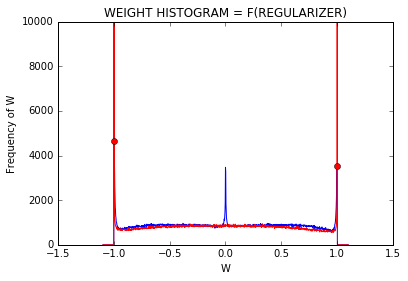

In [13]:
plt.xlabel('W')
plt.ylabel('Frequency of W')
plt.title('WEIGHT HISTOGRAM = F(REGULARIZER)')
plt.ylim(ymax = 10000, ymin = 0)
plt.plot(histogram_det_bi[1][1:1001], histogram_det_bi[0], label='Deterministic BinaryConnect')
plt.plot(histogram_sto_bi[1][1:1001], histogram_sto_bi[0], color='r', label='Stochastic BinaryConnect')
plt.plot(-1.0,max(histogram_det_bi[0][1:501]),'ro')
plt.plot(1.0,max(histogram_det_bi[0][501:1001]),'ro')

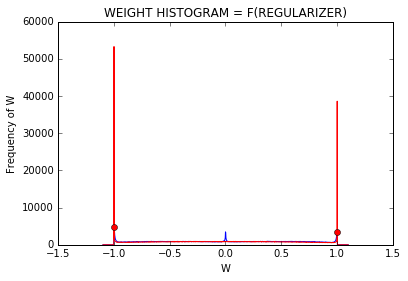

In [15]:
plt.xlabel('W')
plt.ylabel('Frequency of W')
plt.title('WEIGHT HISTOGRAM = F(REGULARIZER)')
plt.plot(histogram_det_bi[1][1:1001], histogram_det_bi[0], label='Deterministic BinaryConnect')
plt.plot(histogram_sto_bi[1][1:1001], histogram_sto_bi[0], color='r', label='Stochastic BinaryConnect')
plt.plot(-1.0,max(histogram_det_bi[0][1:501]),'ro')
plt.plot(1.0,max(histogram_det_bi[0][501:1001]),'ro')

In [17]:
W_no_reg = np.load('./param_no_reg_out.npy')[0].get_value()
W_det_bi = np.load('./param_det_bi_out.npy')[0].get_value()
W_sto_bi = np.load('./param_sto_bi_out.npy')[0].get_value()
W_do = np.load('./param_do_out.npy')[0].get_value()

In [18]:
sign = np.sign(W_det_bi)
absolute = W_det_bi - sign
temp = []
for i in range(W_det_bi.shape[0]):
    temp.append(np.linalg.norm(absolute[i, :], ord=1))
index = sorted(range(len(temp)), key=lambda k: temp[k])

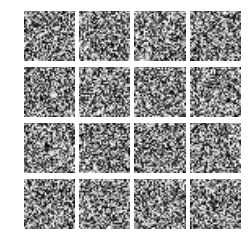

In [19]:
sample_feature_det_bi = W_det_bi[index[0:16], :]
sample_feature_det_bi = sample_feature_det_bi.reshape(4, 4, 32, 32)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(sample_feature_det_bi[i/4, i%4, :, :], cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(left=0, right=0.5, wspace=0.1, hspace=0)
plt.show()

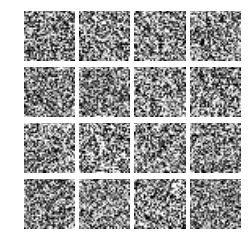

In [20]:
sample_feature_sto_bi = W_sto_bi[index[0:16], :]
sample_feature_sto_bi = sample_feature_sto_bi.reshape(4, 4, 32, 32)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(sample_feature_sto_bi[i/4, i%4, :, :], cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(left=0, right=0.5, wspace=0.1, hspace=0)
plt.show()

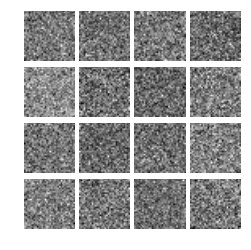

In [21]:
sample_feature_no_reg = W_no_reg[index[0:16], :]
sample_feature_no_reg = sample_feature_no_reg.reshape(4, 4, 32, 32)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(sample_feature_no_reg[i/4, i%4, :, :], cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(left=0, right=0.5, wspace=0.1, hspace=0)
plt.show()

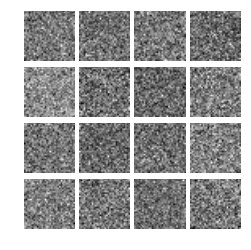

In [22]:
sample_feature_do = W_do[index[0:16], :]
sample_feature_do = sample_feature_do.reshape(4, 4, 32, 32)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(sample_feature_no_reg[i/4, i%4, :, :], cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(left=0, right=0.5, wspace=0.1, hspace=0)
plt.show()